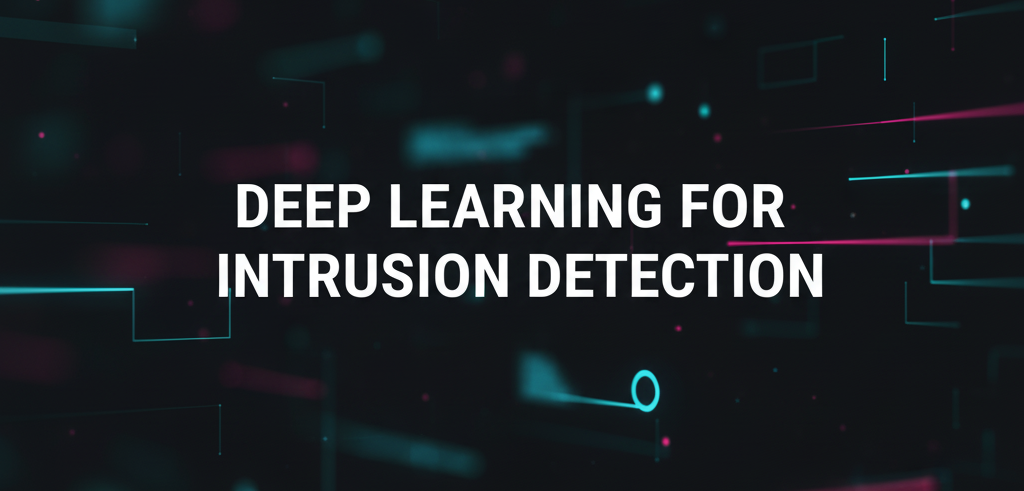



## ***I. Project Overview***

This project focuses on building and evaluating robust Machine Learning models for an Intrusion Detection System (IDS) using a large-scale cybersecurity dataset (likely CICIDS2017 or a similar traffic flow benchmark). Our goal is to perform a two-stage classification:

***Stage 1*** (Binary Classification): Distinguish between Benign (Class 0) traffic and Any Intrusion/Attack (Class 1). This forms the basis of our initial model evaluation.

***Stage 2*** (Multi-Class Classification): Identify the specific type of attack (e.g., Denial of Service, Port Scan, Brute Force).

## ***II. The Core Challenges***

### ***Severe Class Imbalance***

The dataset exhibits a significant class imbalance in the binary problem, with Benign traffic ( 85% of samples) heavily outweighing the Attack traffic ( 15%of samples). This imbalance is critical because a model can achieve deceptively high overall accuracy simply by predicting "Benign" most of the time. Therefore, we prioritize the F1-score for the minority (Attack) class as our key performance metric.

## ***III. Revised Concluding Statement:***

Our analysis proceeds by first establishing a rigorous data preprocessing pipeline, with an emphasis on preventing the data leakage identified during initial runs. Following this, we perform a comparative deep-dive into the performance and reliability of three distinct models (Logistic Regression, Random Forest, and XGBoost) on the Binary Classification task. The final phase of the project involves selecting the most robust and generalized model, XGBoost, and adapting its architecture and tuning strategy to successfully handle the critical multi-class classification challenge.


# ***0 Setting environment***

In [1]:
import sklearn
try:
    import imblearn
    imblearn_version = imblearn.__version__
except ImportError:
    imblearn_version = "Not installed"

print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn_version)


scikit-learn version: 1.2.2
imbalanced-learn version: Not installed


In [2]:
#!pip install scikit-learn==1.2.2 --quiet

In [3]:
!pip install imbalanced-learn==0.9.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 4.1 MB/s eta 0:00:00


In [4]:
 
import os
import numpy as np
import time
import pandas as pd
import warnings
from glob import glob
 
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
 
from imblearn.over_sampling import SMOTE
 
import xgboost as xgb
from xgboost import XGBClassifier
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import GlorotUniform, HeUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy

2025-11-09 18:29:56.602364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762712997.006162      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762712997.117109      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ***1.Data prepration***

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cicids2017/Benign-Monday-no-metadata.parquet
/kaggle/input/cicids2017/Bruteforce-Tuesday-no-metadata.parquet
/kaggle/input/cicids2017/Portscan-Friday-no-metadata.parquet
/kaggle/input/cicids2017/WebAttacks-Thursday-no-metadata.parquet
/kaggle/input/cicids2017/DoS-Wednesday-no-metadata.parquet
/kaggle/input/cicids2017/DDoS-Friday-no-metadata.parquet
/kaggle/input/cicids2017/Infiltration-Thursday-no-metadata.parquet
/kaggle/input/cicids2017/Botnet-Friday-no-metadata.parquet


In [6]:
df_data_1 = pd.read_parquet('/kaggle/input/cicids2017/Benign-Monday-no-metadata.parquet')
df_data_2 = pd.read_parquet('/kaggle/input/cicids2017/Bruteforce-Tuesday-no-metadata.parquet')
df_data_3 = pd.read_parquet('/kaggle/input/cicids2017/Portscan-Friday-no-metadata.parquet')
df_data_4 = pd.read_parquet('/kaggle/input/cicids2017/WebAttacks-Thursday-no-metadata.parquet')
df_data_5 = pd.read_parquet('/kaggle/input/cicids2017/DoS-Wednesday-no-metadata.parquet')
df_data_6 = pd.read_parquet('/kaggle/input/cicids2017/DDoS-Friday-no-metadata.parquet')
df_data_7 = pd.read_parquet('/kaggle/input/cicids2017/Infiltration-Thursday-no-metadata.parquet')
df_data_8 = pd.read_parquet('/kaggle/input/cicids2017/Botnet-Friday-no-metadata.parquet')

In [7]:
df_data = pd.concat([df_data_1, df_data_2, df_data_3, df_data_4, 
                     df_data_5, df_data_6, df_data_7, df_data_8], axis=0, ignore_index=True)

 # **1.1Preprocessing**

In [8]:
df_numeric = df_data.select_dtypes(include=[np.number])

infinity_counts = np.isinf(df_numeric).sum()

infinity_counts

Protocol                    0
Flow Duration               0
Total Fwd Packets           0
Total Backward Packets      0
Fwd Packets Length Total    0
                           ..
Active Min                  0
Idle Mean                   0
Idle Std                    0
Idle Max                    0
Idle Min                    0
Length: 77, dtype: int64

In [9]:
df_data.isnull().sum()

Protocol                    0
Flow Duration               0
Total Fwd Packets           0
Total Backward Packets      0
Fwd Packets Length Total    0
                           ..
Idle Mean                   0
Idle Std                    0
Idle Max                    0
Idle Min                    0
Label                       0
Length: 78, dtype: int64

In [10]:
df_numeric =df_numeric.replace([np.inf, -np.inf], np.nan)
df_numeric = df_numeric.dropna()

In [11]:
df_data.duplicated().sum()

82004

In [12]:
df_data = df_data.drop_duplicates()

In [13]:
X = df_data.copy()
X = X.drop(columns='Label') 
y = df_data["Label"].copy()
y_b = y.map({'Benign': 0}).fillna(1).astype(int).rename('Label')


In [14]:
df_binary = X.copy()
df_binary['Label'] = y_b

# ***1.2 EDA***

## ***1.2.1 For all dataset***

In [15]:
 df_data.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [16]:
print(df_data.columns.tolist())

['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ra

In [17]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231806 entries, 0 to 2313809
Data columns (total 78 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Protocol                  int8   
 1   Flow Duration             int32  
 2   Total Fwd Packets         int32  
 3   Total Backward Packets    int32  
 4   Fwd Packets Length Total  int32  
 5   Bwd Packets Length Total  int32  
 6   Fwd Packet Length Max     int16  
 7   Fwd Packet Length Min     int16  
 8   Fwd Packet Length Mean    float32
 9   Fwd Packet Length Std     float32
 10  Bwd Packet Length Max     int16  
 11  Bwd Packet Length Min     int16  
 12  Bwd Packet Length Mean    float32
 13  Bwd Packet Length Std     float32
 14  Flow Bytes/s              float64
 15  Flow Packets/s            float64
 16  Flow IAT Mean             float32
 17  Flow IAT Std              float32
 18  Flow IAT Max              int32  
 19  Flow IAT Min              int32  
 20  Fwd IAT Total             int

## ***1.2.2 Binary class***

In [18]:
df_binary['Label'].value_counts()

Label
0    1895314
1     336492
Name: count, dtype: int64

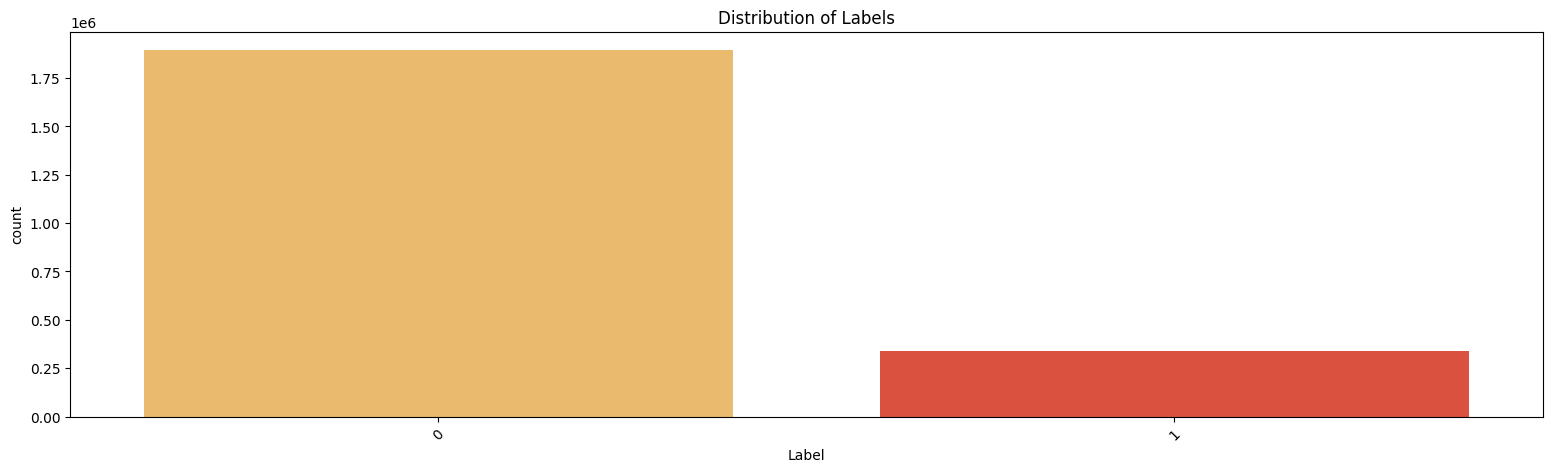

In [19]:
plt.figure(figsize=(19,5))
sns.countplot(x=df_binary['Label'], palette="YlOrRd")
plt.title("Distribution of Labels")
plt.xticks(rotation=45)
plt.show()

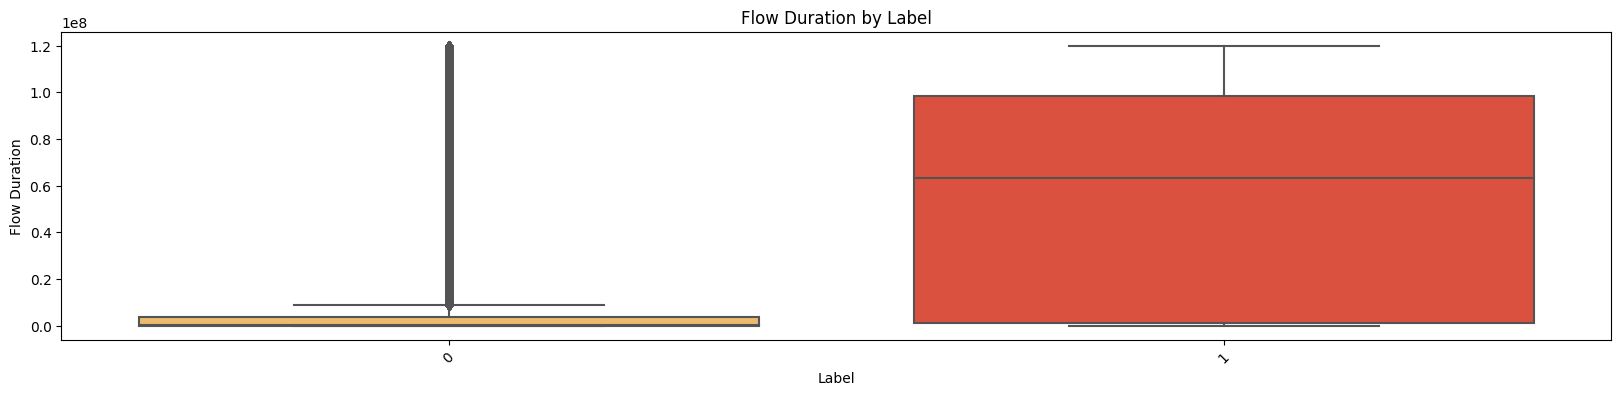

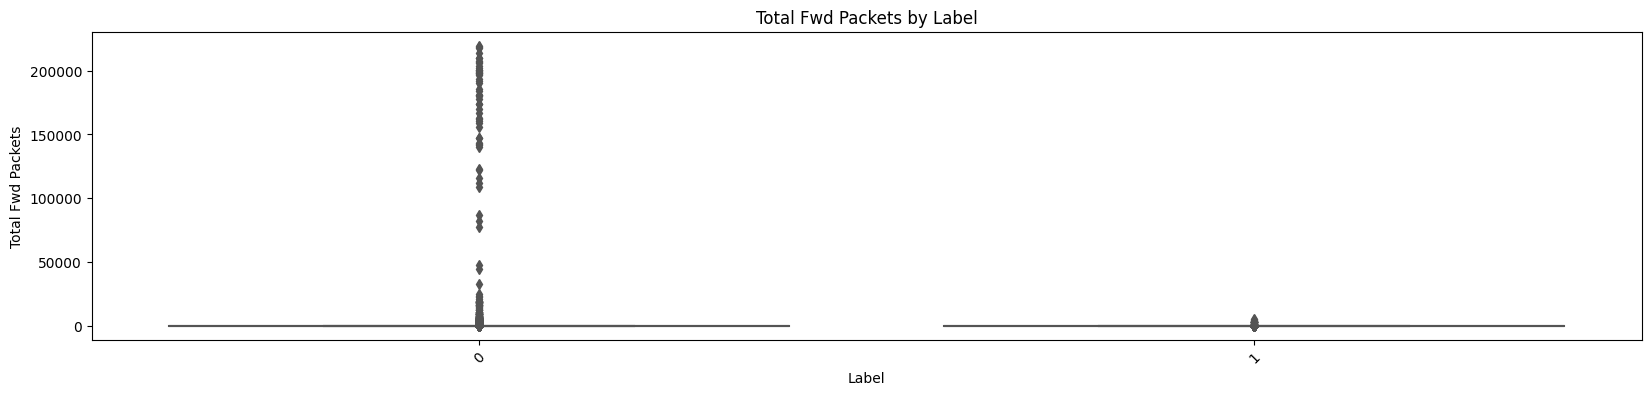

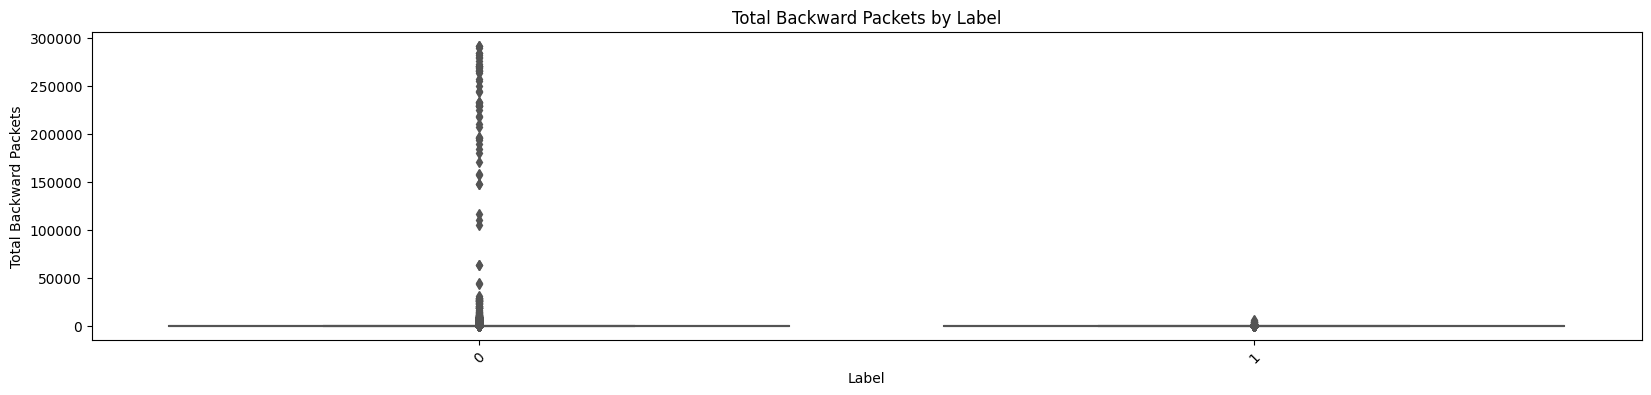

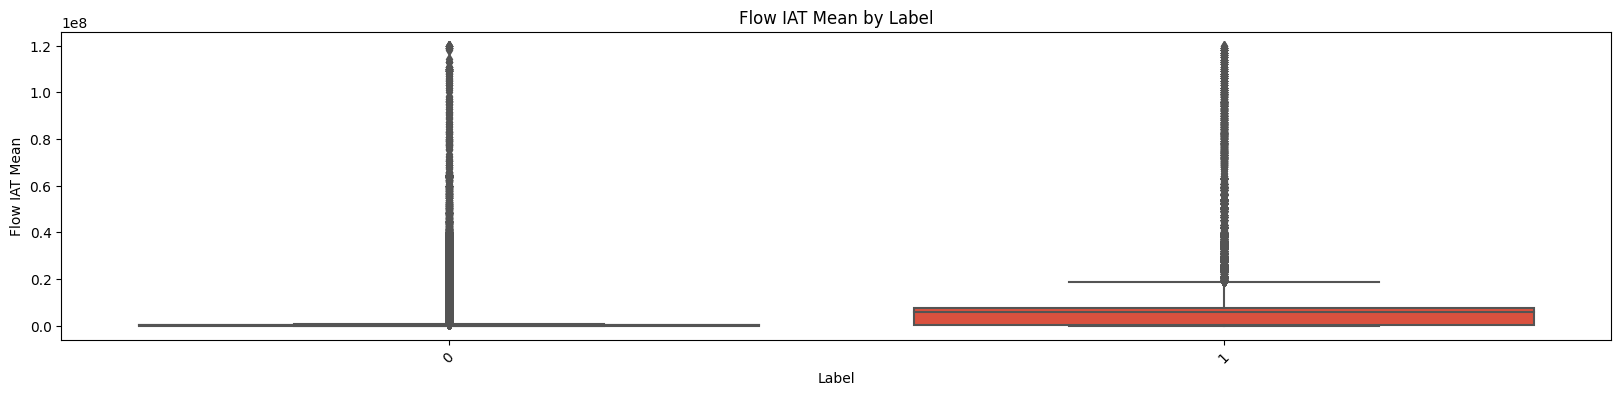

In [20]:
features_to_plot = ['Flow Duration','Total Fwd Packets','Total Backward Packets','Flow IAT Mean']
for feat in features_to_plot:
    plt.figure(figsize=(20,4))
    sns.boxplot(x='Label', y=feat, data=df_binary,palette="YlOrRd")
    plt.title(f'{feat} by Label')
    plt.xticks(rotation=45)
    plt.show()


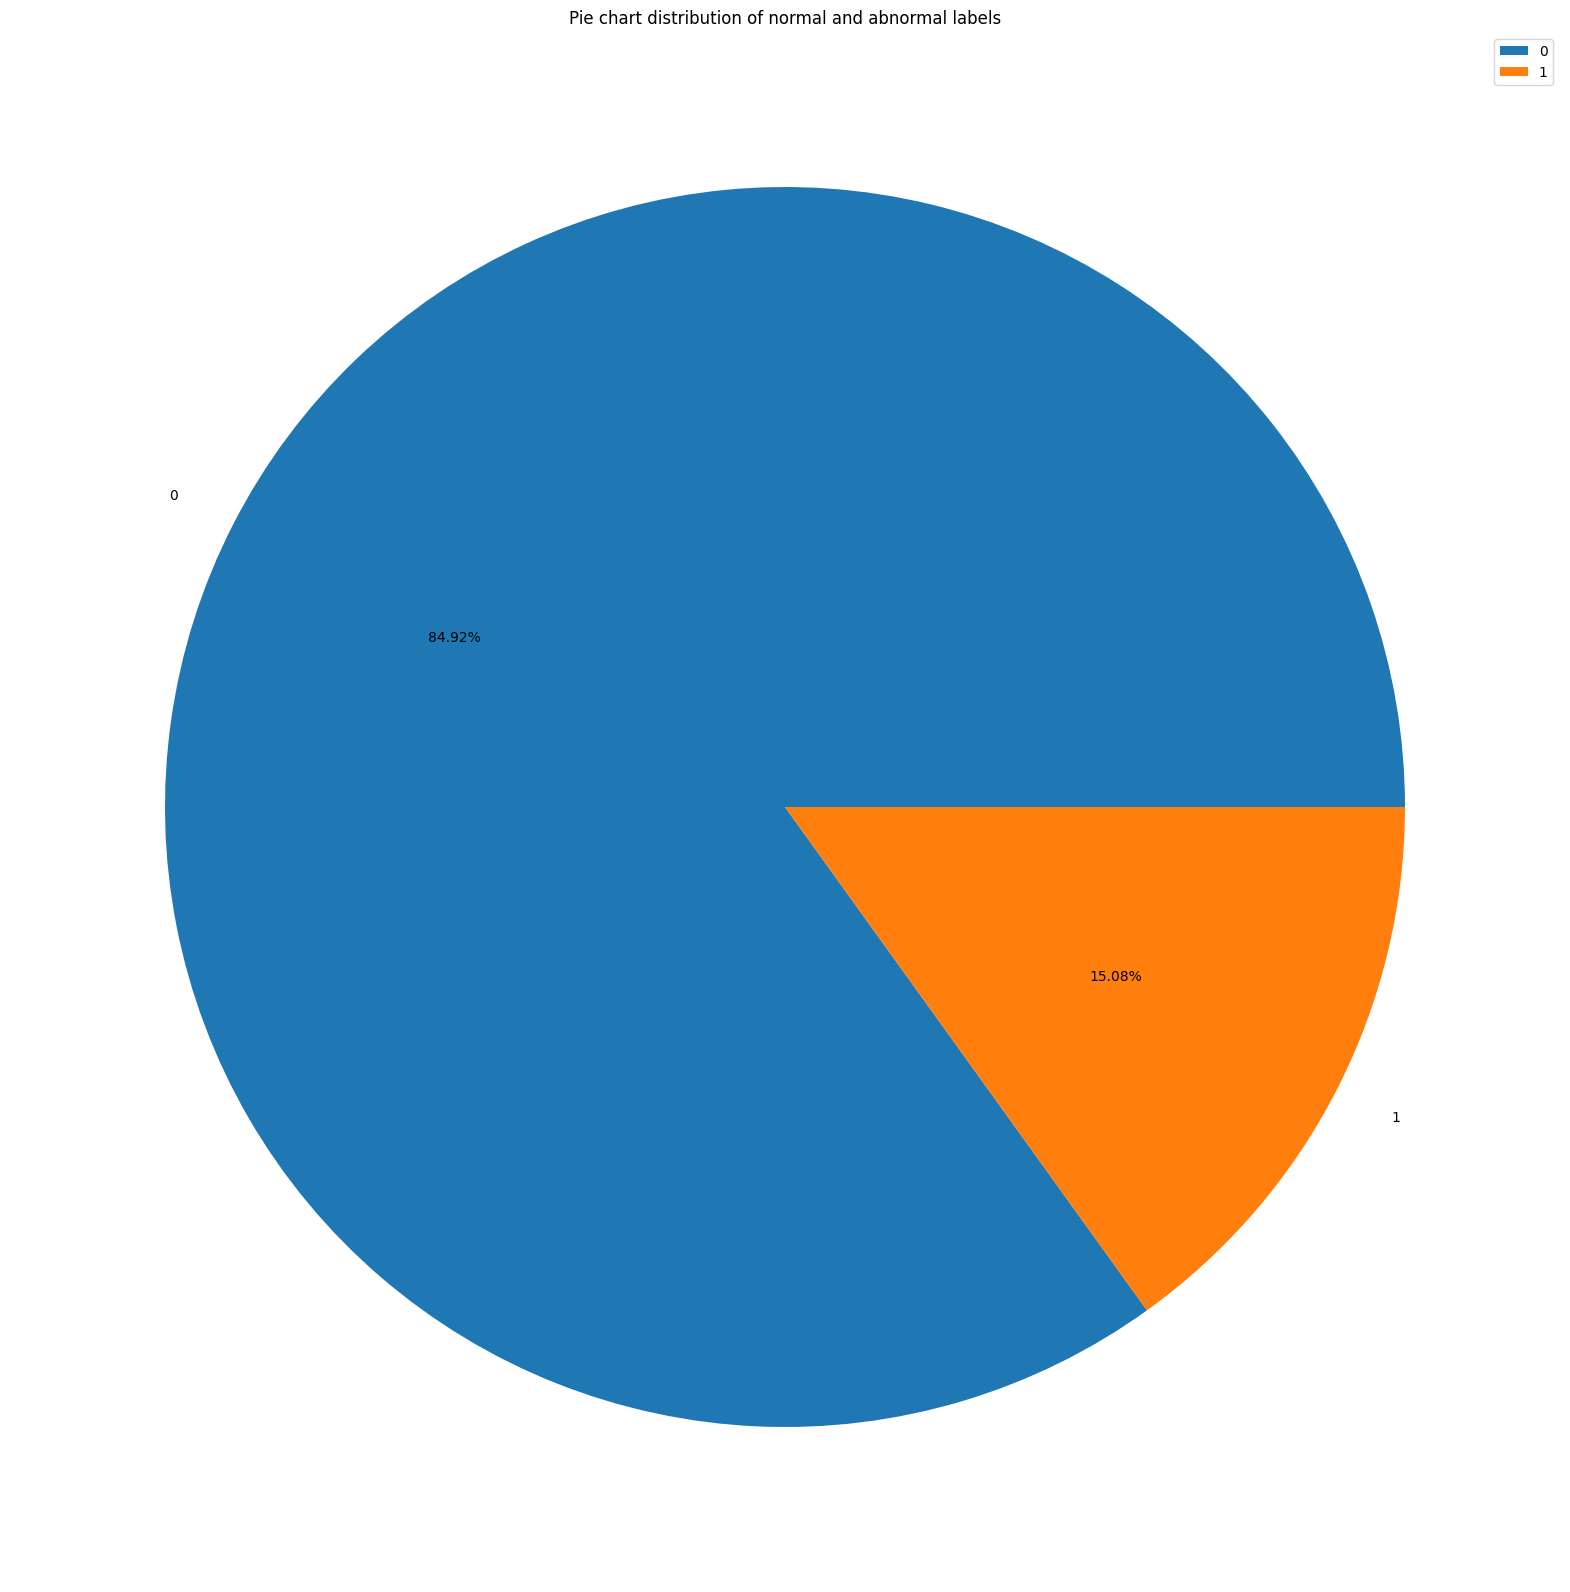

In [21]:
plt.figure(figsize=(20,30))
plt.pie(df_binary['Label'].value_counts(),labels=df_binary['Label'].unique(),autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels")
plt.legend()
plt.show()

## ***1.2.3 Multiclass***

In [22]:
df_data['Label'].value_counts()

Label
Benign                        1895314
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [23]:
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Protocol,2231806.0,1.047114e+01,5.409536e+00,0.0,6.0,6.0,17.00,17.0
Flow Duration,2231806.0,1.873981e+07,3.690288e+07,-13.0,2037.0,77109.5,6055696.75,119999998.0
Total Fwd Packets,2231806.0,1.142387e+01,8.442820e+02,1.0,2.0,2.0,7.00,219759.0
Total Backward Packets,2231806.0,1.296894e+01,1.123261e+03,0.0,1.0,2.0,6.00,291922.0
Fwd Packets Length Total,2231806.0,6.886546e+02,1.125057e+04,0.0,39.0,74.0,365.00,12900000.0
...,...,...,...,...,...,...,...,...
Active Min,2231806.0,7.394033e+04,6.490405e+05,0.0,0.0,0.0,1.00,110000000.0
Idle Mean,2231806.0,1.054639e+07,2.630308e+07,0.0,0.0,0.0,5132033.00,120000000.0
Idle Std,2231806.0,6.390577e+05,5.156686e+06,0.0,0.0,0.0,0.00,76900000.0
Idle Max,2231806.0,1.102800e+07,2.696824e+07,0.0,0.0,0.0,5132054.25,120000000.0


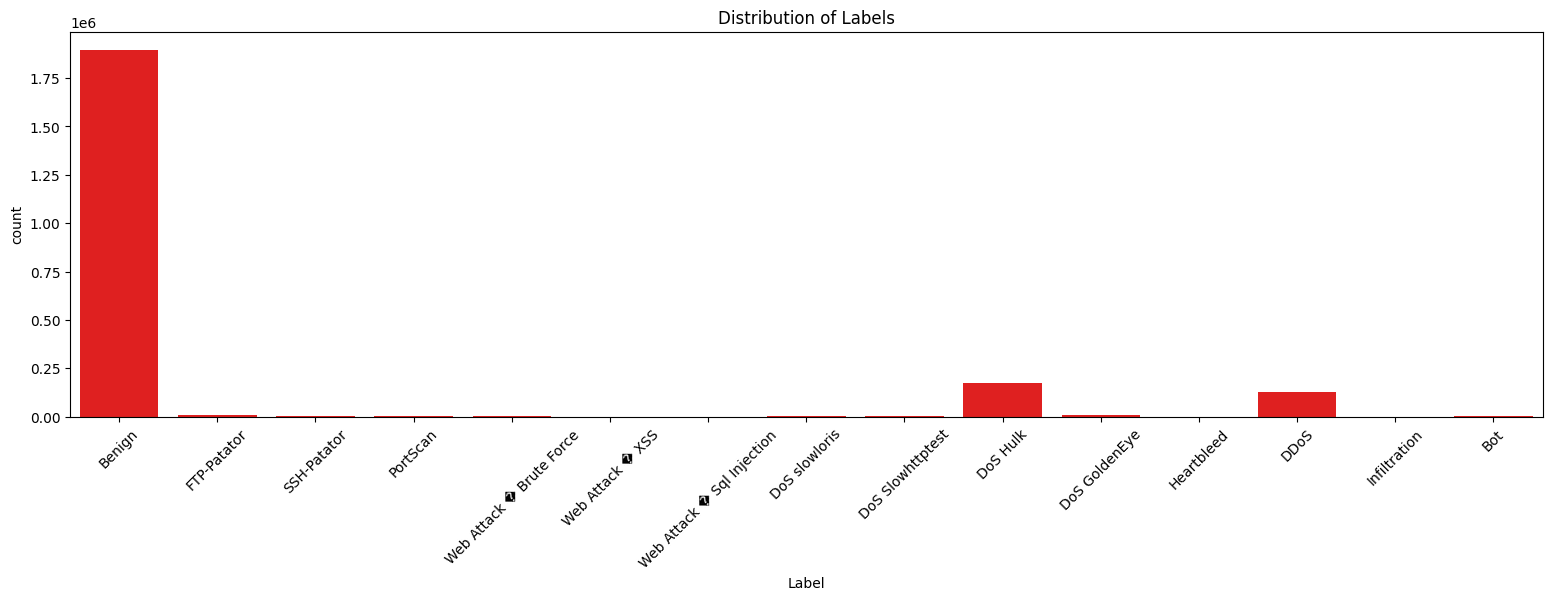

In [24]:
plt.figure(figsize=(19,5))
sns.countplot(x=df_data['Label'], color="red")
plt.title("Distribution of Labels")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


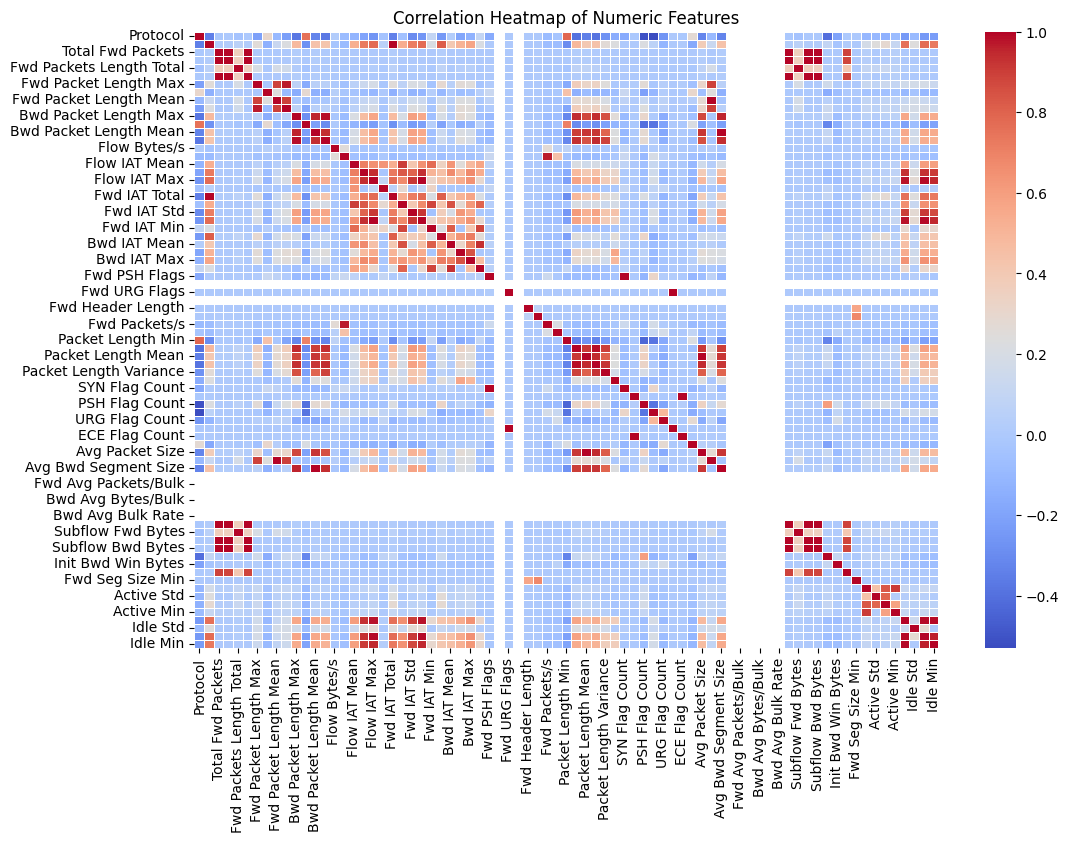

In [25]:
plt.figure(figsize=(12,8))
corr = df_numeric.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5,)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


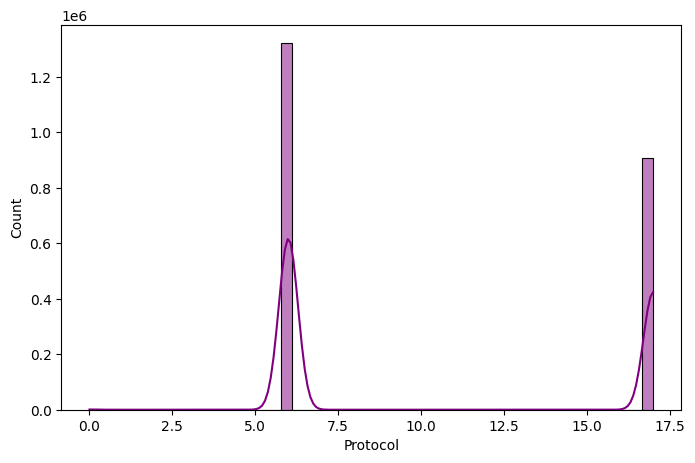

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df_data['Protocol'], bins=50, kde=True, color="purple")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


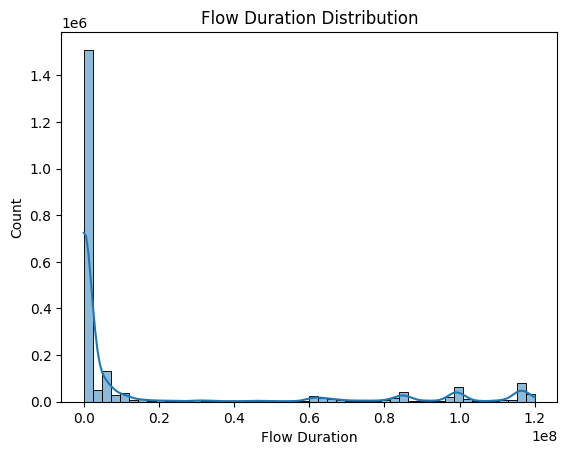

In [27]:
sns.histplot(df_data['Flow Duration'], bins=50, kde=True)
plt.title("Flow Duration Distribution")
plt.show()

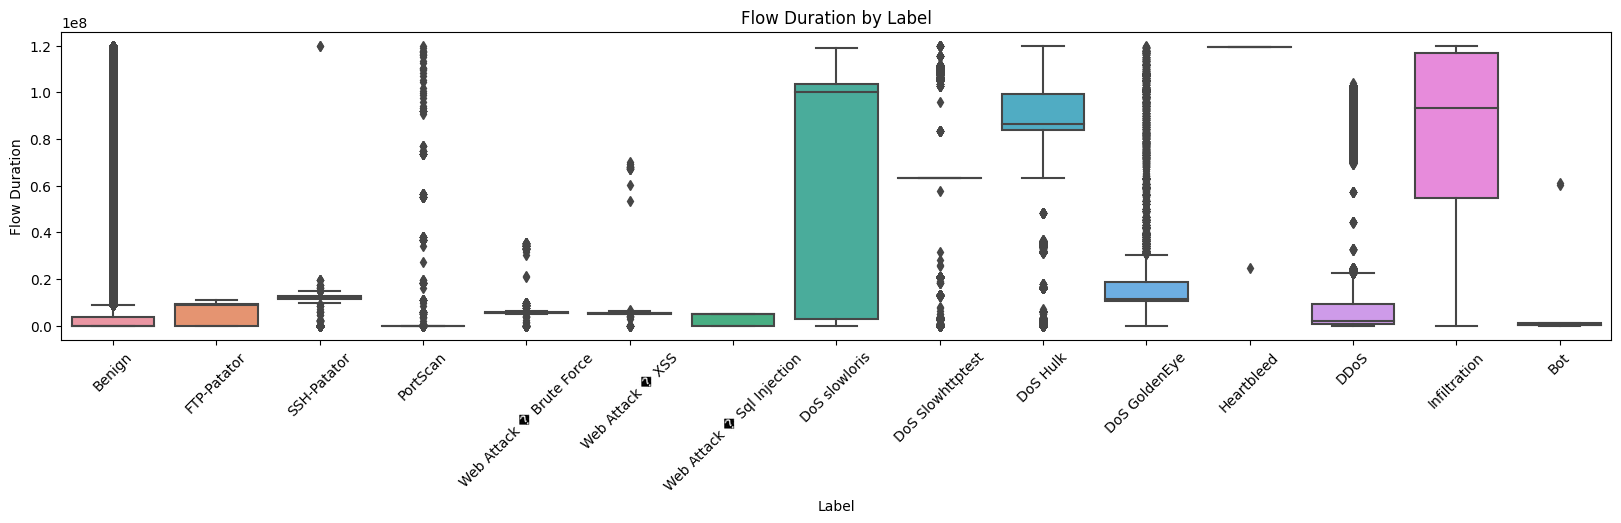

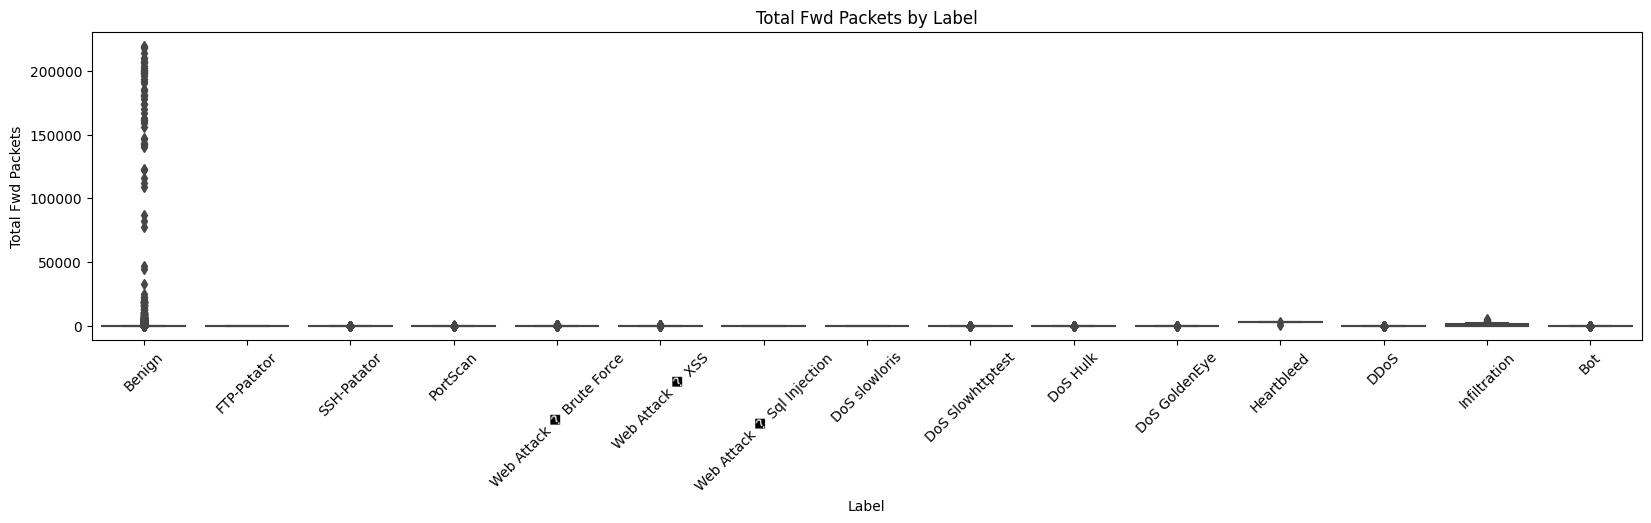

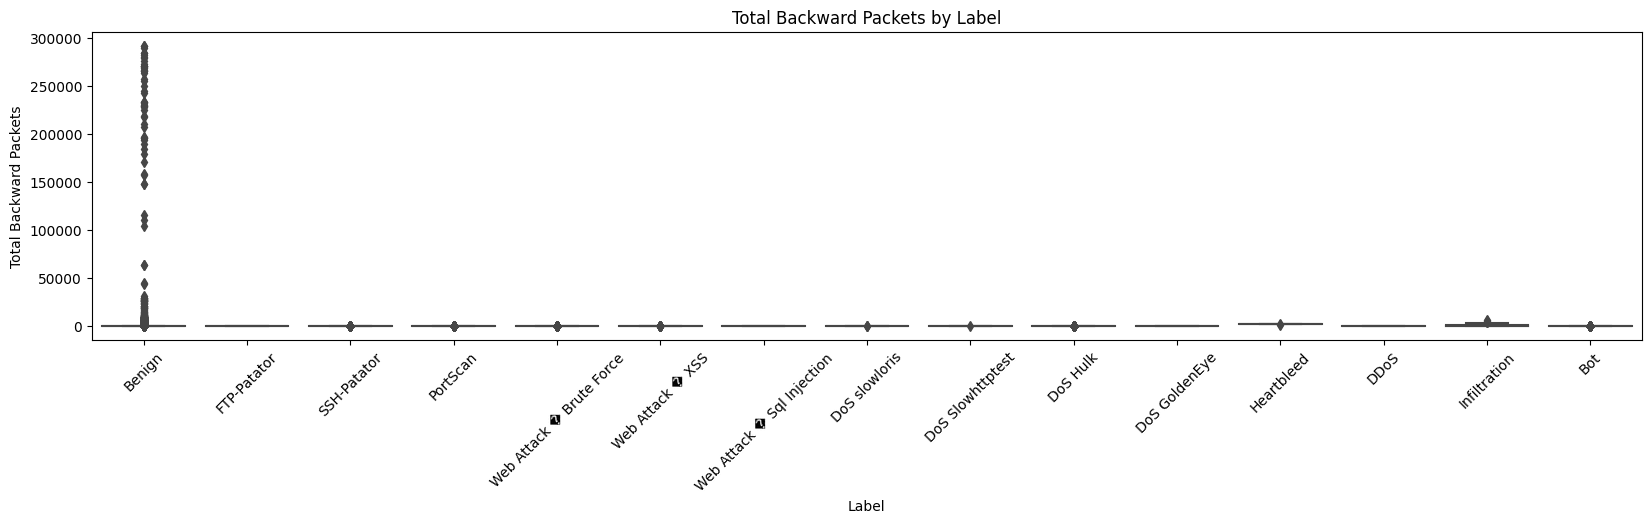

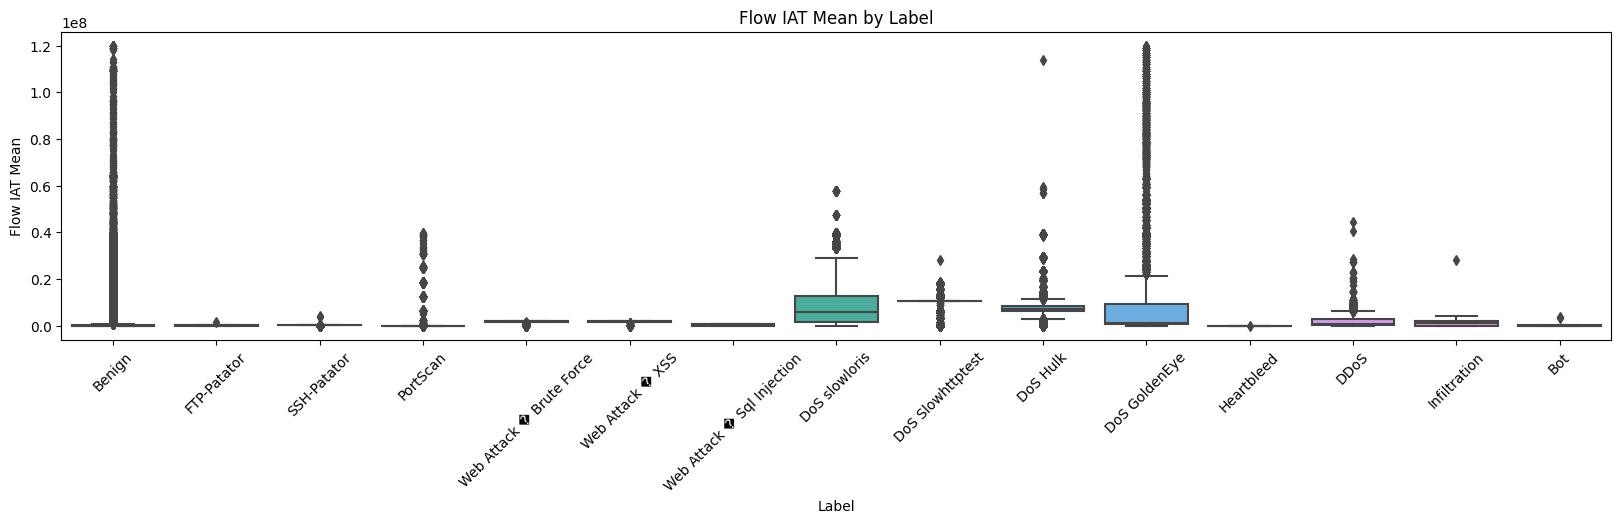

In [28]:
features_to_plot = ['Flow Duration','Total Fwd Packets','Total Backward Packets','Flow IAT Mean']
for feat in features_to_plot:
    plt.figure(figsize=(20,4))
    sns.boxplot(x='Label', y=feat, data=df_data)
    plt.title(f'{feat} by Label')
    plt.xticks(rotation=45)
    plt.show()


# ***1.3 Grouping Labels***

In [29]:

threshold = 1300  

counts = df_data['Label'].value_counts()

other_classes = counts[counts < threshold].index
df_data['Label'] = df_data['Label'].apply(lambda x: 'Other' if x in other_classes else x)


print(df_data['Label'].value_counts())


Label
Benign                      1895314
DoS Hulk                     172846
DDoS                         128014
DoS GoldenEye                 10286
FTP-Patator                    5931
DoS slowloris                  5385
DoS Slowhttptest               5228
SSH-Patator                    3219
PortScan                       1956
Web Attack � Brute Force       1470
Bot                            1437
Other                           720
Name: count, dtype: int64


In [30]:
X = df_data.copy()
X = X.drop(columns='Label') 
y = df_data["Label"].copy()

# ***1.4 Encoder***

In [31]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_m =y_encoded

# ***1.5 Split Data***

## ***1.5.1 Binary classificatin***

In [32]:
x_train_b,x_temp_b,y_train_b,y_temp_b=train_test_split(X,y_b,
                                                       stratify=y_b
                                                       ,test_size=0.3 
                                                       ,random_state=42)

x_val_b,x_test_b,y_val_b,y_test_b=train_test_split(x_temp_b,y_temp_b
                                                   ,stratify=y_temp_b
                                                   ,test_size=0.3
                                                   ,random_state=42)

## ***1.5.2 Multiclassification***

In [33]:
x_train,x_temp,y_train,y_temp=train_test_split(X,y_encoded
                                               ,stratify=y_encoded
                                               ,test_size=0.3 
                                               ,random_state=42)

x_val,x_test,y_val,y_test=train_test_split(x_temp,y_temp
                                           ,stratify=y_temp
                                           ,test_size=0.3 
                                           ,random_state=42)

# ***1.6 Feature engineering with XGboost***

## ***1.6.1 Binary class***

In [34]:
xgb_fs = XGBClassifier(
    n_estimators=50,       
    max_depth=3,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_fs.fit(X, y_b)

importances = xgb_fs.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [35]:
selector = SelectFromModel(xgb_fs, threshold="median", prefit=True)

X_train_sel_b = selector.transform(x_train_b)
X_val_sel_b   = selector.transform(x_val_b)
X_test_sel_b  = selector.transform(x_test_b)

selected_features = x_train_b.columns[selector.get_support()]

X_trainb_sel_df = pd.DataFrame(X_train_sel_b, columns=selected_features)
X_valb_sel_df   = pd.DataFrame(X_val_sel_b, columns=selected_features)
X_testb_sel_df  = pd.DataFrame(X_test_sel_b, columns=selected_features)


print("Original feature count:", x_train.shape[1])
print("Reduced feature count:", X_train_sel_b.shape[1])

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Original feature count: 77
Reduced feature count: 39


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


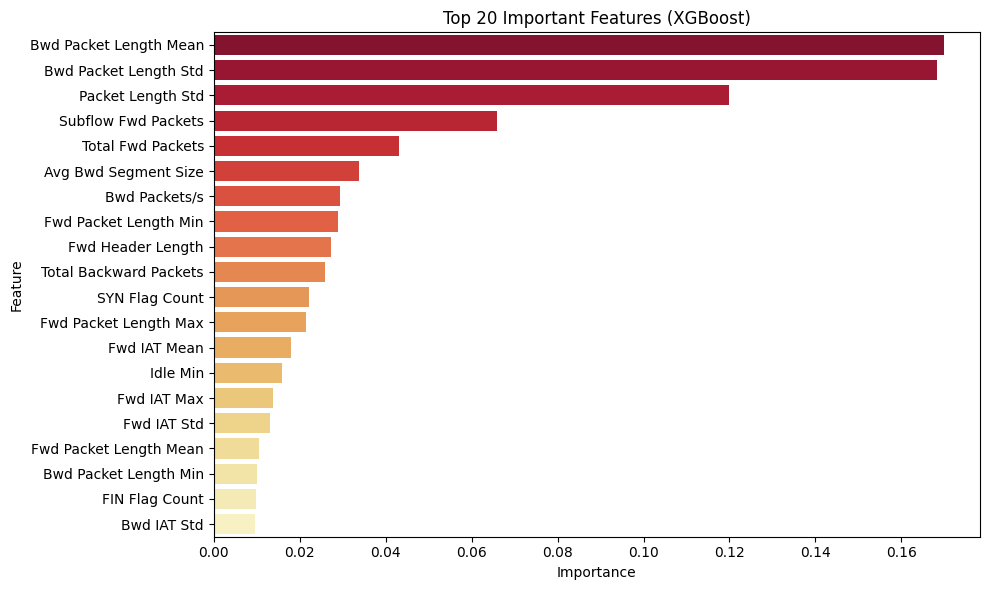

In [36]:
colors = sns.color_palette("YlOrRd", n_colors=20)[::-1] 

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20),palette=colors)
plt.title("Top 20 Important Features (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

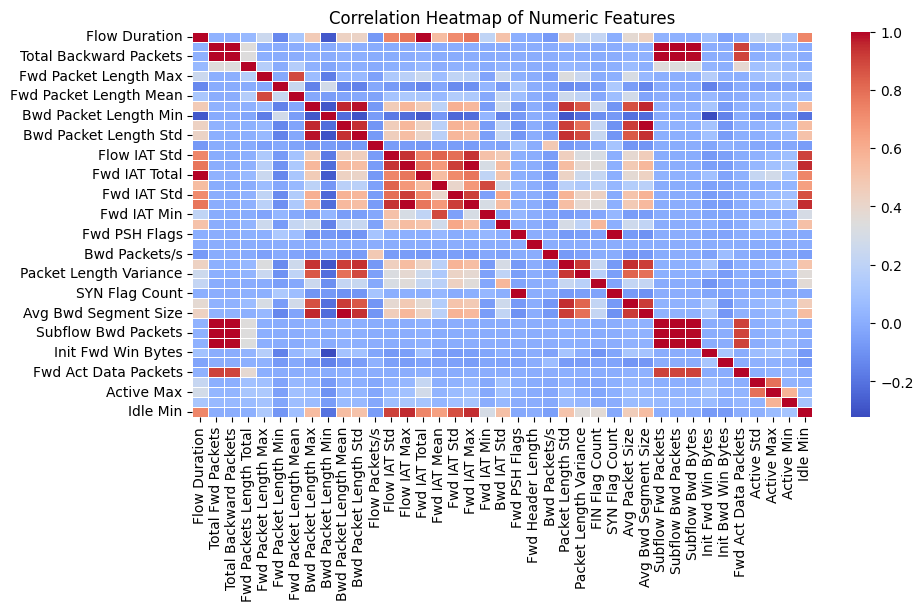

In [37]:
plt.figure(figsize=(10,5))
corr = X_trainb_sel_df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show() 

In [38]:
to_drop = ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
            'Subflow Bwd Packets', 'Active Min', 'Flow IAT Std']

X_trainb_sel_df = X_trainb_sel_df.drop(columns=to_drop)
X_valb_sel_df   = X_valb_sel_df.drop(columns=to_drop)
X_testb_sel_df  = X_testb_sel_df.drop(columns=to_drop)

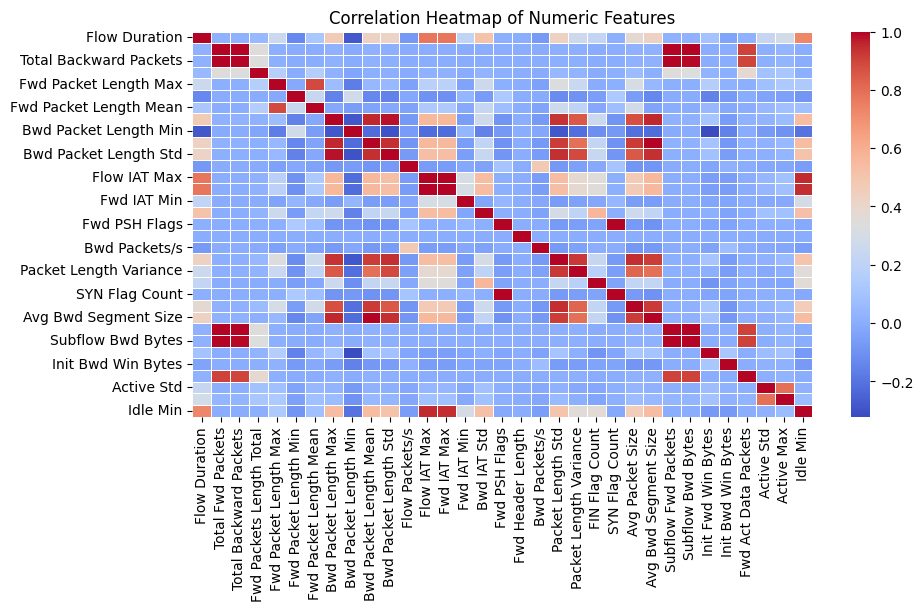

In [39]:
plt.figure(figsize=(10,5))
corr = X_trainb_sel_df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show() 

## ***1.6.2 Multiclass***

In [40]:
xgb_fs = xgb.XGBClassifier(
    n_estimators=50,       
    max_depth=3,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_fs.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

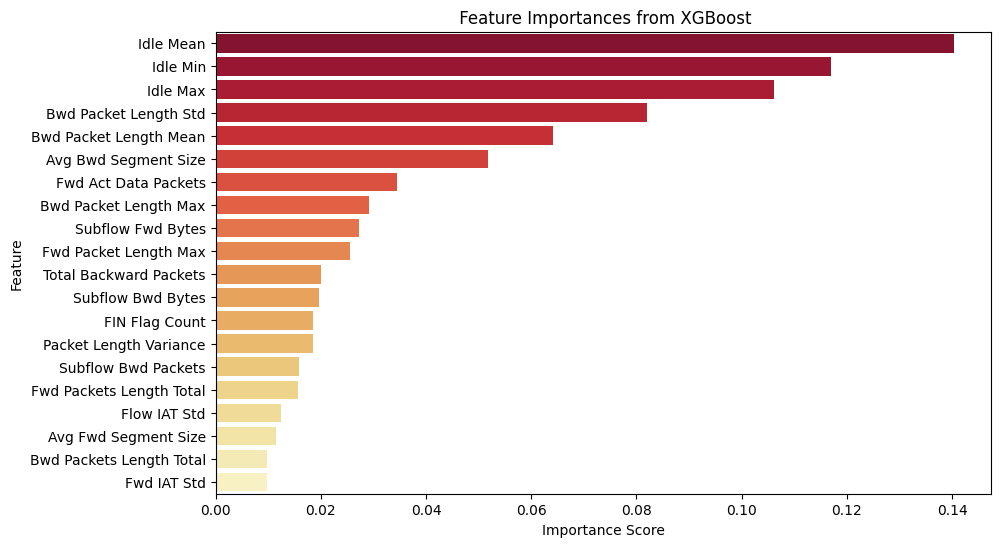

In [41]:
feat_importances = pd.DataFrame({"Feature": x_train.columns,"Importance":
                                 xgb_fs.feature_importances_})

feat_importances = feat_importances.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importances.head(20), x="Importance", y="Feature", palette=colors)
plt.title(" Feature Importances from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [42]:

selector = SelectFromModel(xgb_fs, threshold="median", prefit=True)

X_train_sel = selector.transform(x_train)
X_val_sel   = selector.transform(x_val)
X_test_sel  = selector.transform(x_test)

selected_features = x_train.columns[selector.get_support()]

X_train_sel_df = pd.DataFrame(X_train_sel, columns=selected_features)
X_val_sel_df = pd.DataFrame(X_val_sel, columns=selected_features)
X_test_sel_df = pd.DataFrame(X_test_sel, columns=selected_features)


print("Original feature count:", x_train.shape[1])
print("Reduced feature count:", X_train_sel.shape[1])


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Original feature count: 77
Reduced feature count: 39


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [43]:
to_drop = ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
            'Subflow Bwd Packets', 'Flow IAT Std']

X_train_sel_df = X_train_sel_df.drop(columns=to_drop)
X_val_sel_df   = X_val_sel_df .drop(columns=to_drop)
X_test_sel_df  = X_test_sel_df.drop(columns=to_drop)

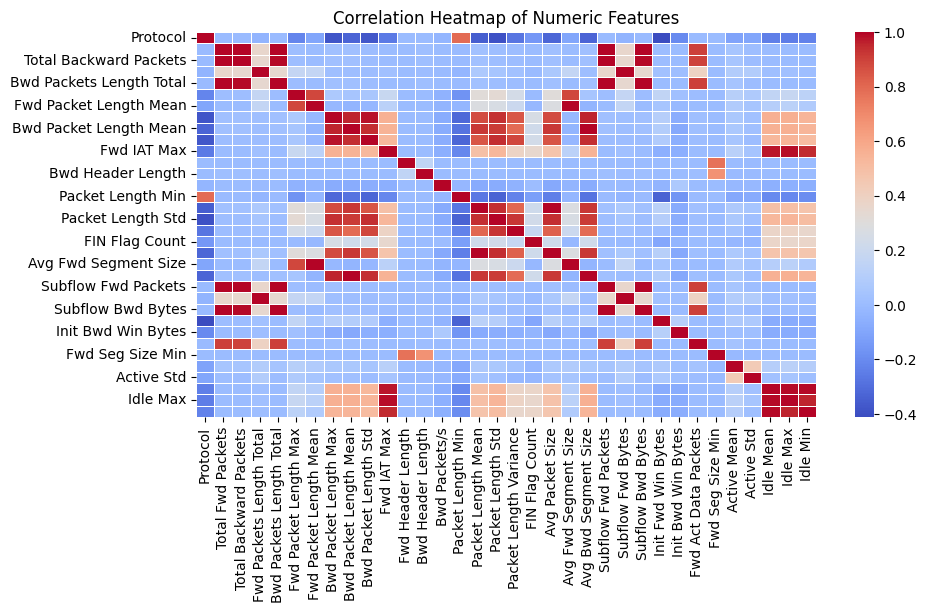

In [44]:
plt.figure(figsize=(10,5))
corr = X_train_sel_df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show() 

# ***1.7 Scaling***

## ***1.7.1 Binary classification***

In [45]:
scaler_bin = MinMaxScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_trainb_sel_df)
X_val_bin_scaled   = scaler_bin.transform(X_valb_sel_df)
X_test_bin_scaled  = scaler_bin.transform(X_testb_sel_df)

## ***1.7.2 Multi Classification***

In [46]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_sel_df)
X_val_scaled   = scaler.transform(X_val_sel_df)
X_test_scaled  = scaler.transform(X_test_sel_df)

# ***1.8 Balancing***

## ***1.8.1 Binary classification***

In [47]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_bin_scaled, y_train_b)

print("Before SMOTE:", y_train_b.value_counts())
print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: Label
0    1326720
1     235544
Name: count, dtype: int64
After SMOTE: Label
0    1326720
1    1326720
Name: count, dtype: int64


## ***1.8.2 Multiclassification*** 

In [48]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# ***2 Model training***

In [49]:
del df_data_1,df_data_2,df_data_3,df_data_4,df_data_5,df_data_6,df_data_7,df_data_8,df_numeric

del x_train_b, x_val_b, x_test_b
del X_trainb_sel_df,X_valb_sel_df,X_testb_sel_df
del X_train_bin_scaled

del df_data, x_train, x_val, x_test,other_classes,to_drop,feat_importances,X_train_sel,X_val_sel,X_test_sel
del X_train_sel_df,X_val_sel_df,X_test_sel_df

# ***2.1 Binary classification***

## ***2.1.1 Classification Models***

### ***A.Logestic regression***

 * Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    170579
           1       0.67      0.94      0.78     30284

    accuracy                           0.92    200863
   macro avg       0.83      0.93      0.87    200863
weighted avg       0.94      0.92      0.93    200863



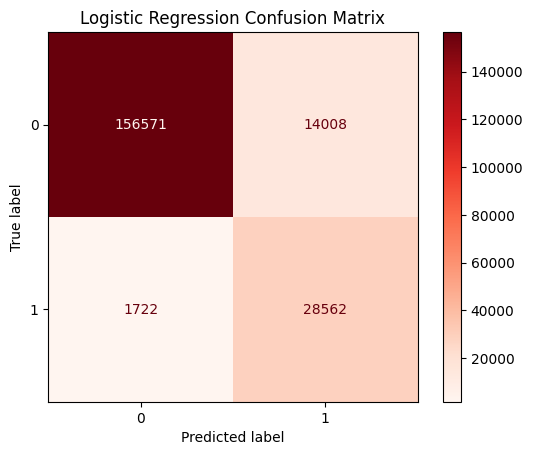

In [50]:
log_reg_pipeline = Pipeline([
    ('model', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

log_reg_pipeline.fit(X_train_smote, y_train_smote)
y_pred_lr = log_reg_pipeline.predict(X_test_bin_scaled)

print(" * Logistic Regression Report:")
print(classification_report(y_test_b, y_pred_lr))
ConfusionMatrixDisplay.from_estimator(log_reg_pipeline, X_test_bin_scaled, y_test_b, cmap='Reds')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

 * ***The Logistic Regression model***: shows high accuracy (93%), but its performance is unbalanced: it detects most attacks (high recall) but misclassifies many normal samples as attacks (low precision). This indicates underfitting / high bias, meaning the model is too simple for the dataset. More complex models handle the data better.

### ***b.Random forest***

Cross-Validation Results 3:
Accuracy: 0.999 ± 0.000
Precision (macro): 0.999
Recall (macro): 0.999
F1-score (macro): 0.999
--------------------------------------------------
Random Forest Report on Test Set:
              precision    recall  f1-score   support

           0      1.000     0.999     0.999    170579
           1      0.995     0.999     0.997     30284

    accuracy                          0.999    200863
   macro avg      0.997     0.999     0.998    200863
weighted avg      0.999     0.999     0.999    200863



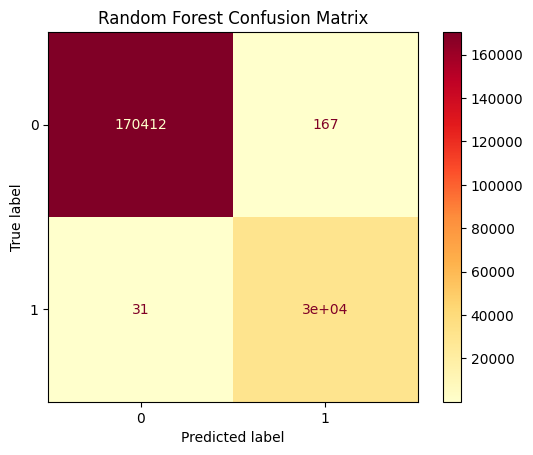

In [51]:

rf_pipeline = Pipeline([
    ('model', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced_subsample'
    ))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    rf_pipeline, 
    X_train_smote, 
    y_train_smote, 
    cv=cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)


print("Cross-Validation Results 3:")
print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.3f} ± {np.std(cv_results['test_accuracy']):.3f}")
print(f"Precision (macro): {np.mean(cv_results['test_precision_macro']):.3f}")
print(f"Recall (macro): {np.mean(cv_results['test_recall_macro']):.3f}")
print(f"F1-score (macro): {np.mean(cv_results['test_f1_macro']):.3f}")
print("-" * 50)

rf_pipeline.fit(X_train_smote, y_train_smote)


y_pred_rf = rf_pipeline.predict(X_test_bin_scaled)

print("Random Forest Report on Test Set:")
print(classification_report(y_test_b, y_pred_rf, digits=3))


ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test_bin_scaled, y_test_b, cmap='YlOrRd')
plt.title("Random Forest Confusion Matrix")
plt.show()


### ***c.XGboost***

In [52]:

xgb_model = XGBClassifier(
    n_estimators=200,     
    learning_rate=0.05,   
    max_depth=3,          
    min_child_weight=5,   
    subsample=0.7, 
    colsample_bytree=0.7,
    reg_alpha=1,          
    reg_lambda=1,         
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(
    X_train_smote, 
    y_train_smote,
    eval_set=[(X_test_bin_scaled, y_test_b)],
    early_stopping_rounds=10,
    verbose=True
)

y_pred_xgb = xgb_model.predict(X_test_bin_scaled)

val_accuracy = accuracy_score(y_test_b, y_pred_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65331
[1]	validation_0-logloss:0.61689
[2]	validation_0-logloss:0.58357
[3]	validation_0-logloss:0.55215
[4]	validation_0-logloss:0.52407
[5]	validation_0-logloss:0.49811
[6]	validation_0-logloss:0.47416
[7]	validation_0-logloss:0.45168
[8]	validation_0-logloss:0.43104
[9]	validation_0-logloss:0.41212
[10]	validation_0-logloss:0.39406
[11]	validation_0-logloss:0.37745
[12]	validation_0-logloss:0.36183
[13]	validation_0-logloss:0.34658
[14]	validation_0-logloss:0.33247
[15]	validation_0-logloss:0.31991
[16]	validation_0-logloss:0.30754
[17]	validation_0-logloss:0.29599
[18]	validation_0-logloss:0.28509
[19]	validation_0-logloss:0.27530
[20]	validation_0-logloss:0.26534
[21]	validation_0-logloss:0.25618
[22]	validation_0-logloss:0.24762
[23]	validation_0-logloss:0.23974
[24]	validation_0-logloss:0.23205
[25]	validation_0-logloss:0.22479
[26]	validation_0-logloss:0.21787
[27]	validation_0-logloss:0.21161
[28]	validation_0-logloss:0.20526
[29]	validation_0-loglos

 * XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170579
           1       0.98      0.99      0.98     30284

    accuracy                           0.99    200863
   macro avg       0.99      0.99      0.99    200863
weighted avg       0.99      0.99      0.99    200863

Validation Accuracy: 0.994498737945764


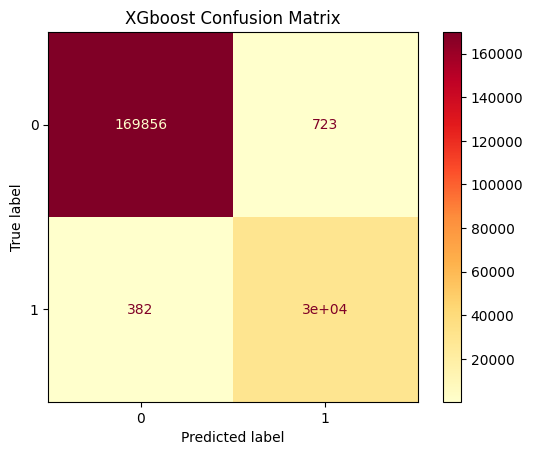

In [53]:
print(" * XGBoost Report:")
print(classification_report(y_test_b, y_pred_xgb))
print("Validation Accuracy:", val_accuracy)
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_bin_scaled, y_test_b, cmap='YlOrRd')
plt.title("XGboost Confusion Matrix")
plt.show()

## ***2.1.2 MLP model***

In [54]:
input_shape = X_train_smote.shape[1]

In [55]:
#  model_1_b  "minimal" architecture
model_1_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(8, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

#  model_2_b  "intermediate" architecture
model_2_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(8,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])
model_3_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(32, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

# model_4_b  "intermediate" architecture
model_4_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(128, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(32,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(16,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,   activation='sigmoid', kernel_initializer=GlorotUniform())])

#  model_5_b "maximal" architecture
model_5_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(256, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(128, activation='selu',    kernel_initializer=HeUniform()),
    Dense(64,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(32,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(16,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,   activation='sigmoid', kernel_initializer=GlorotUniform())])

models_b = [model_1_b, model_2_b, model_3_b, model_4_b, model_5_b]

I0000 00:00:1762715741.258797      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762715741.259608      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [56]:

# Define Early Stopping callback to monitor validation loss
early_stopping_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=8,                # Stop training after 10 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=4,                # Default value for patience is 10
    min_lr= 1e-07,             # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=0,                 # Providing verbose output when learning rate is reduced
    factor= 0.1)               # The default factor is 0.1, which reduces 
                               # the learning rate by 10% when triggered.
    
compilation_params_b = dict(
    optimizer='adam',          # Adam optimizer has default learning rate 1e-03
    loss='binary_crossentropy',# Binary crossentropy corresponds to binary Configuration 
    metrics=['accuracy'])      # montitor accuracy during training


In [57]:
# Training Session for `model_1_b`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_1_b.compile(**compilation_params_b) 

fitting_params_b = dict(x=X_train_smote, y=y_train_smote, validation_data=(X_val_bin_scaled, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)


history_1_b = model_1_b.fit(**fitting_params_b)

I0000 00:00:1762715746.930868     127 service.cc:148] XLA service 0x7e7fd80050b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762715746.932257     127 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762715746.932279     127 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762715747.312387     127 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762715748.485233     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 5.


In [58]:
# Training Session for `model_2_b`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_2_b.compile(**compilation_params_b) 

fitting_params_b = dict(x=X_train_smote ,y=y_train_smote, validation_data=(X_val_bin_scaled, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

history_2_b = model_2_b.fit(**fitting_params_b)

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 8.


In [59]:
# Training Session for `model_3_b`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_3_b.compile(**compilation_params_b) 

fitting_params_b = dict(x=X_train_smote, y=y_train_smote, validation_data=(X_val_bin_scaled, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)


history_3_b = model_3_b.fit(**fitting_params_b)

Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.


In [60]:
# Training Session for `model_4_b`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_4_b.compile(**compilation_params_b) 

fitting_params_b = dict(x=X_train_smote, y=y_train_smote, validation_data=(X_val_bin_scaled, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

history_4_b = model_4_b.fit(**fitting_params_b)

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 3.


In [61]:
# Training Session for `model_5_b`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_5_b.compile(**compilation_params_b) 

fitting_params_b = dict(x=X_train_smote, y=y_train_smote, validation_data=(X_val_bin_scaled, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

history_5_b = model_5_b.fit(**fitting_params_b)

Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 4.


In [62]:
def evaluate_b(model, X_test, y_test):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels)
    recall    = recall_score(y_test, y_pred_labels)
    f1        = f1_score(y_test, y_pred_labels)

    # Print the evaluation metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1 Score:  {f1*100:.2f}%")
    print("")
    return test_loss, test_accuracy, precision, recall, f1
    
[loss_1_b, acc_1_b, prec_1_b, recall_1_b, f1_1_b] = evaluate_b(model=model_1_b, 
                                              X_test=X_test_bin_scaled, y_test=y_test_b)
[loss_2_b, acc_2_b, prec_2_b, recall_2_b, f1_2_b] = evaluate_b(model=model_2_b, 
                                              X_test=X_test_bin_scaled, y_test=y_test_b)
[loss_3_b, acc_3_b, prec_3_b, recall_3_b, f1_3_b] = evaluate_b(model=model_3_b, 
                                              X_test=X_test_bin_scaled, y_test=y_test_b)
[loss_4_b, acc_4_b, prec_4_b, recall_4_b, f1_4_b] = evaluate_b(model=model_4_b, 
                                              X_test=X_test_bin_scaled, y_test=y_test_b)
[loss_5_b, acc_5_b, prec_5_b, recall_5_b, f1_5_b] = evaluate_b(model=model_5_b, 
                                              X_test=X_test_bin_scaled, y_test=y_test_b)

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9765 - loss: 0.0709
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Test Loss:      0.0711
Test Accuracy:  97.60%
Test Precision: 89.77%
Test Recall:    94.87%
Test F1 Score:  92.25%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9854 - loss: 0.0503
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Test Loss:      0.0507
Test Accuracy:  98.52%
Test Precision: 96.07%
Test Recall:    94.04%
Test F1 Score:  95.05%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9774 - loss: 0.0799
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Test Loss:      0.0805
Test Accuracy:  97.72%
Test Precision: 91.67%
Test Recall:    93.38%
Test F1 Score:  92.51%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9868 - loss: 0.0489
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Test Loss:      0.0495
Test Accuracy:  98.67%
Test Precision: 96.45%
Test Recall:    94.66%
Test F1 Score:  95.55%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accura

In [63]:
def far_amr_b(model, X_test=X_test_bin_scaled, y_test=y_test_b, plotting=True):
    """
    Advanced evaluation through False Alarm Ratio (FAR) & Attack Miss Ratio (AMR).
    """
    
    y_pred = model.predict(X_test)

    y_pred_labels = (y_pred > 0.5).astype(int)
    
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    if plotting:
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    # Calculate FAR:
    true_positives  = conf_matrix[0,0]
    false_positives = conf_matrix[0,1] 
    all_positives   = true_positives + false_positives
    far = false_positives / all_positives
    #Calculate AMR:
    false_negatives = conf_matrix[1,0] 
    true_negatives  = conf_matrix[1,1]
    all_negatives   = true_negatives + false_negatives
    amr = false_negatives / all_negatives
    return far, amr
    
far_1_b, amr_1_b = far_amr_b(model_1_b, plotting=False)
far_2_b, amr_2_b = far_amr_b(model_2_b, plotting=False)
far_3_b, amr_3_b = far_amr_b(model_3_b, plotting=False)
far_4_b, amr_4_b = far_amr_b(model_4_b, plotting=False)
far_5_b, amr_5_b = far_amr_b(model_5_b, plotting=False)

print("")
print(f"Model_1_b: (FAR, AMR) = ({far_1_b:.4f}, {amr_1_b:.4f})")
print(f"Model_2_b: (FAR, AMR) = ({far_2_b:.4f}, {amr_2_b:.4f})")
print(f"Model_3_b: (FAR, AMR) = ({far_3_b:.4f}, {amr_3_b:.4f})")
print(f"Model_4_b: (FAR, AMR) = ({far_4_b:.4f}, {amr_4_b:.4f})")
print(f"Model_5_b: (FAR, AMR) = ({far_5_b:.4f}, {amr_5_b:.4f})")


6277/6277 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

Model_1_b: (FAR, AMR) = (0.0192, 0.0513)
Model_2_b: (FAR, AMR) = (0.0068, 0.0596)
Model_3_b: (FAR, AMR) = (0.0151, 0.0662)
Model_4_b: (FAR, AMR) = (0.0062, 0.0534)
Model_5_b: (FAR, AMR) = (0.0147, 0.0419)


History for model_1_b



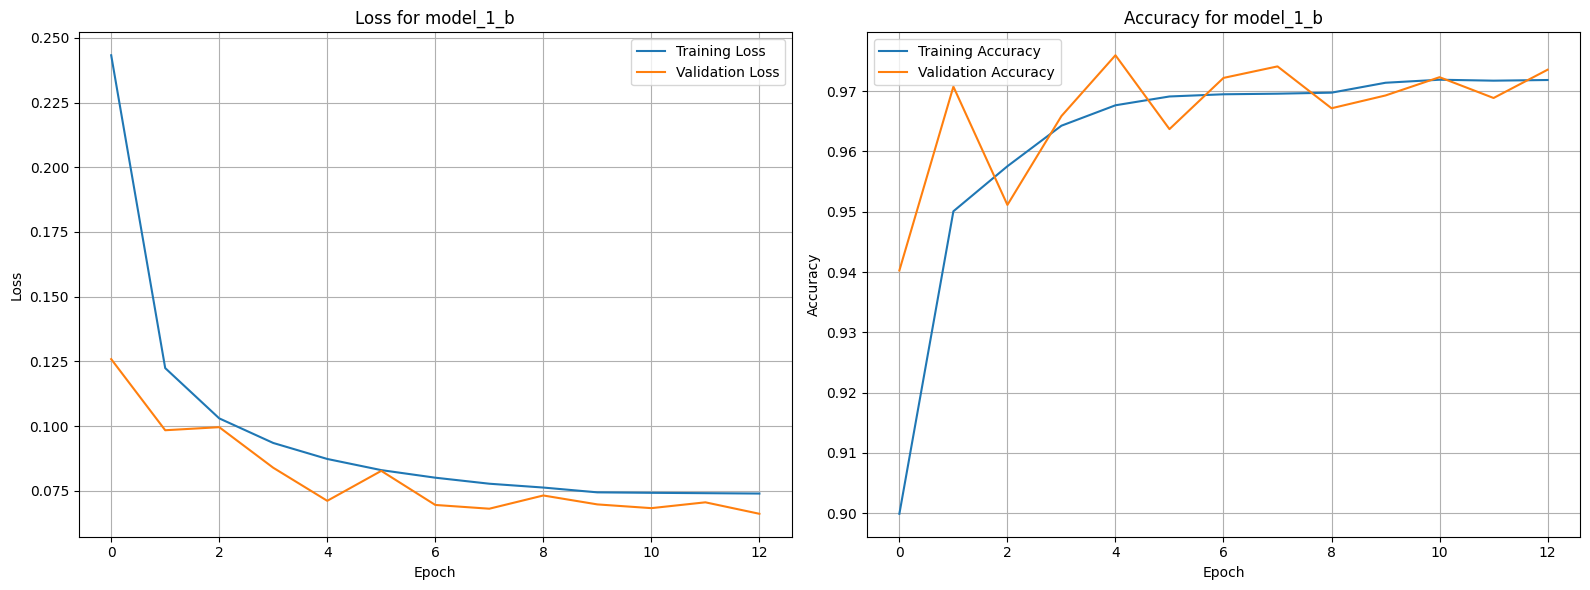


History for model_2_b



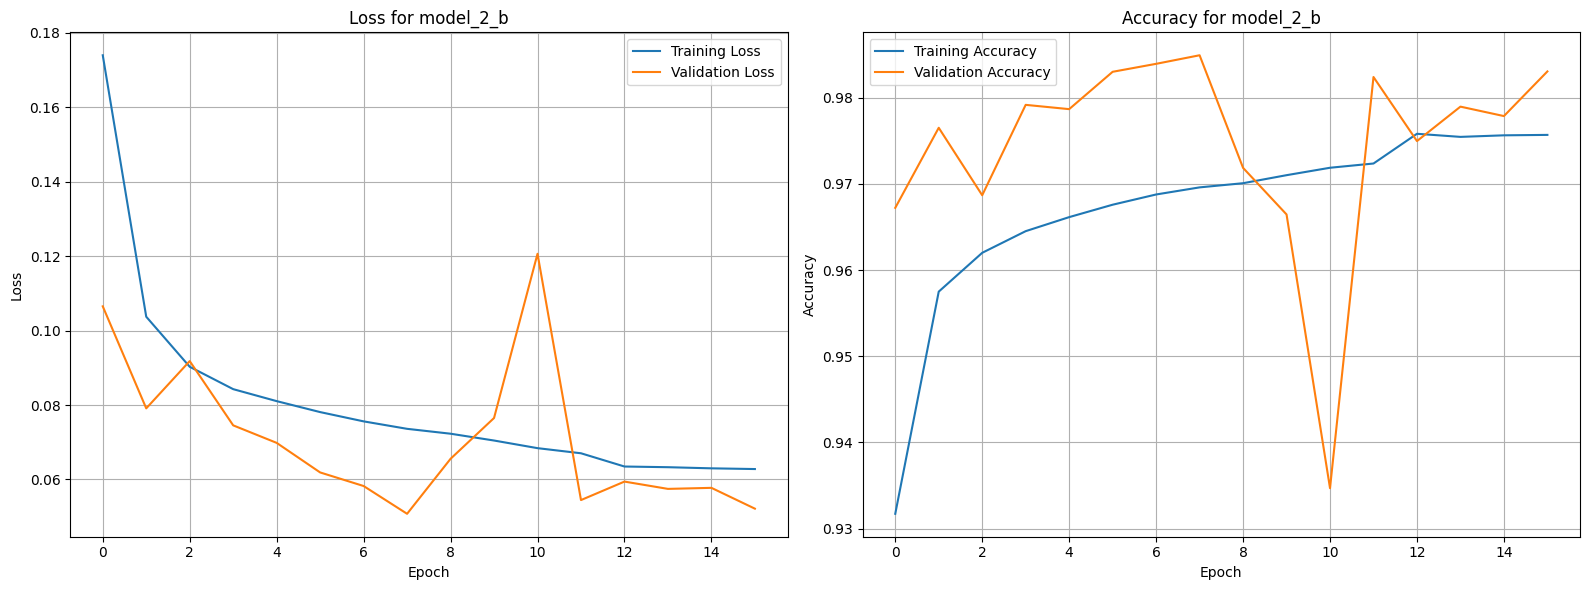


History for model_3_b



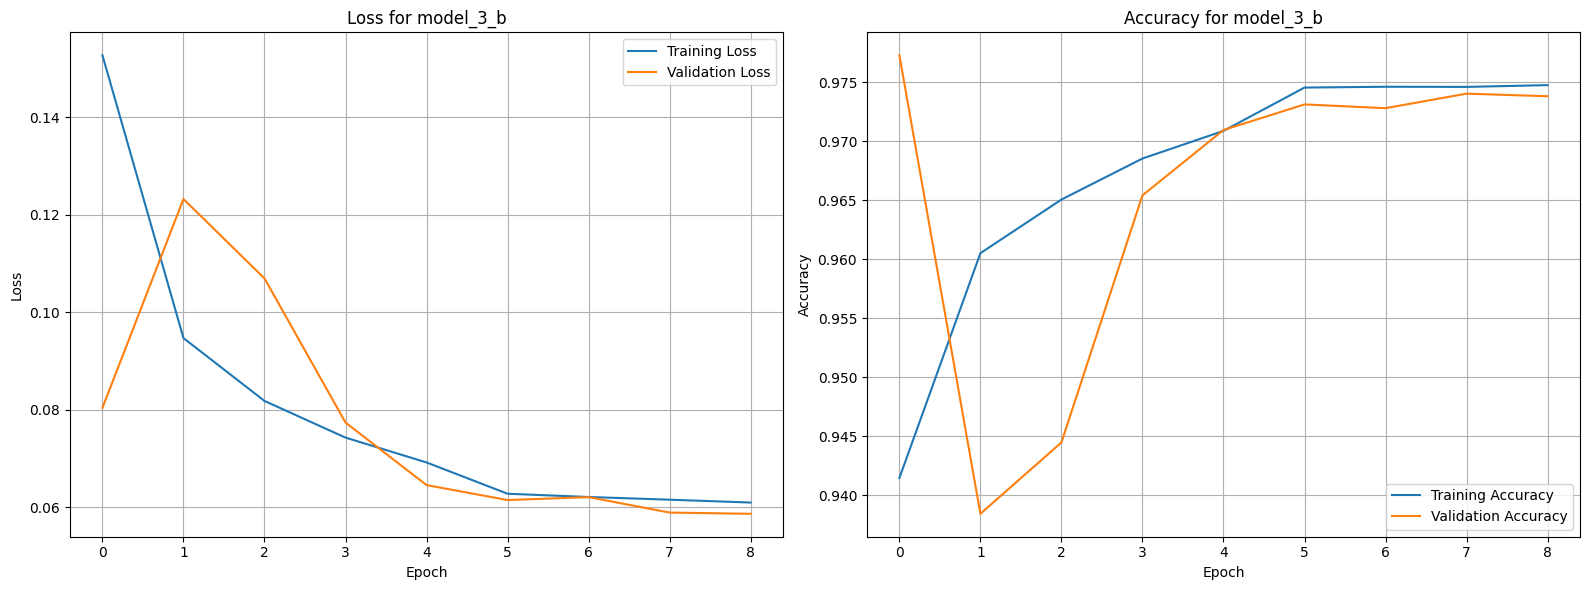


History for model_4_b



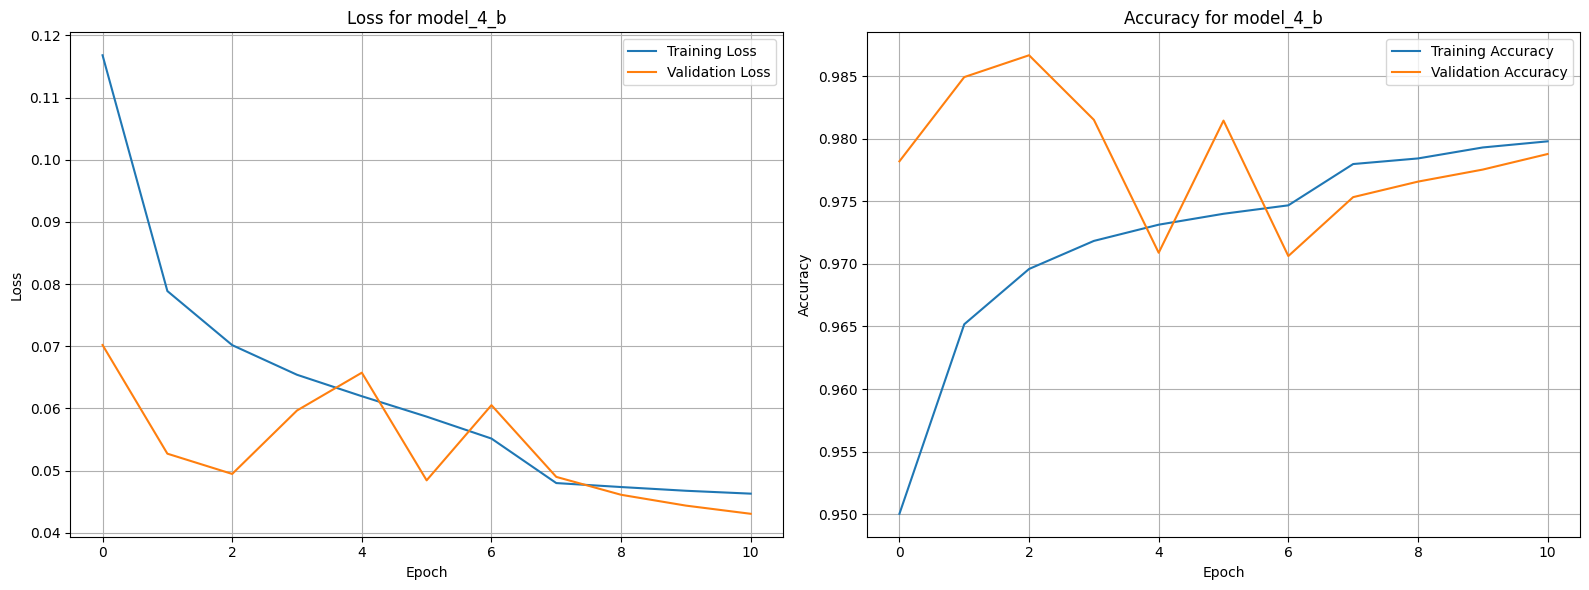


History for model_5_b



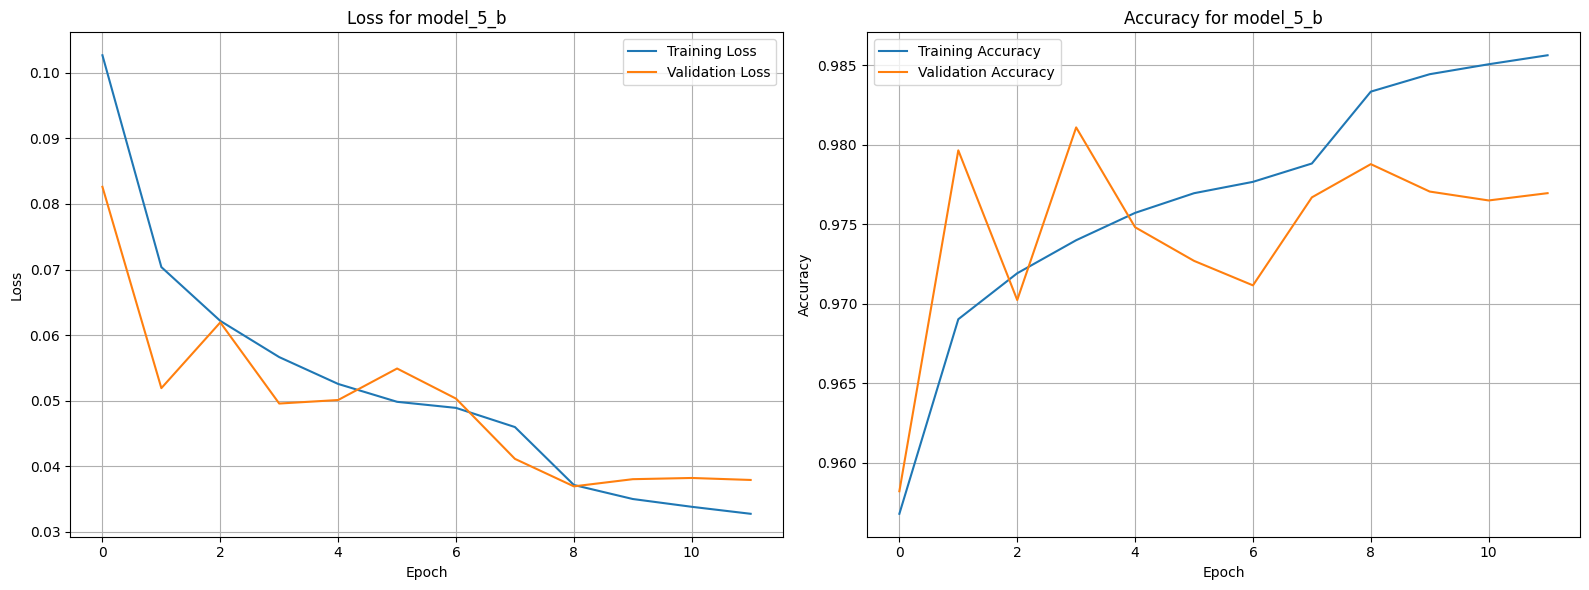

In [64]:

def history_plot(history, model_name):
    """
    Plotting the loss & accuracy history of the model
    """
    # Suppress FutureWarnings within this function
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Extract training and validation loss/accuracy from history
        train_loss = history.history['loss']
        val_loss   = history.history['val_loss']
        train_acc  = history.history['accuracy']
        val_acc    = history.history['val_accuracy']

        # Create a figure and axes for subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
        
        # Plot loss curves
        sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axes[0], label='Training Loss')
        sns.lineplot(x=range(len(val_loss)),   y=val_loss, ax=axes[0], label='Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'Loss for {model_name}')
        axes[0].legend()
        axes[0].grid(True)

        # Plot accuracy curves
        sns.lineplot(x=range(len(train_acc)), y=train_acc, ax=axes[1], label='Training Accuracy')
        sns.lineplot(x=range(len(val_acc)),   y=val_acc, ax=axes[1], label='Validation Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'Accuracy for {model_name}')
        axes[1].legend()
        axes[1].grid(True)

        # Adjust layout
        plt.tight_layout()

        # Display the plot
        plt.show()


print("History for model_1_b\n")
history_plot(history_1_b, "model_1_b")
print("")
print("History for model_2_b\n")
history_plot(history_2_b, "model_2_b")
print("")
print("History for model_3_b\n")
history_plot(history_3_b, "model_3_b")
print("")
print("History for model_4_b\n")
history_plot(history_4_b, "model_4_b")
print("")
print("History for model_5_b\n")
history_plot(history_5_b, "model_5_b")

In [65]:
def latency(model, sample_data):
    start_time = time.time()
    model.predict(sample_data)
    end_time = time.time()
    latency = (end_time - start_time) / len(sample_data)
    return latency

# Measure & Print latency
print(f"Latency for model_1_b: {latency(model_1_b, X_test_bin_scaled)*1000:.3f} ms") # Results: 0.049 m-seconds
print(f"Latency for model_2_b: {latency(model_2_b, X_test_bin_scaled)*1000:.3f} ms") # Results: 0.048 m-seconds
print(f"Latency for model_3_b: {latency(model_3_b, X_test_bin_scaled)*1000:.3f} ms") # Results: 0.061 m-seconds
print(f"Latency for model_4_b: {latency(model_4_b, X_test_bin_scaled)*1000:.3f} ms") # Results: 0.050 m-seconds
print(f"Latency for model_5_b: {latency(model_5_b, X_test_bin_scaled)*1000:.3f} ms") # Results: 0.061 m-seconds

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Latency for model_1_b: 0.051 ms
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Latency for model_2_b: 0.051 ms
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Latency for model_3_b: 0.051 ms
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Latency for model_4_b: 0.052 ms
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Latency for model_5_b: 0.053 ms


In [66]:
y_pred_1_b = (model_1_b.predict(X_test_bin_scaled) > 0.5).astype(int)
y_pred_2_b = (model_2_b.predict(X_test_bin_scaled) > 0.5).astype(int)
y_pred_3_b = (model_3_b.predict(X_test_bin_scaled) > 0.5).astype(int)
y_pred_4_b = (model_4_b.predict(X_test_bin_scaled) > 0.5).astype(int)
y_pred_5_b = (model_5_b.predict(X_test_bin_scaled) > 0.5).astype(int)

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


Confusion Matrix for model_1_b



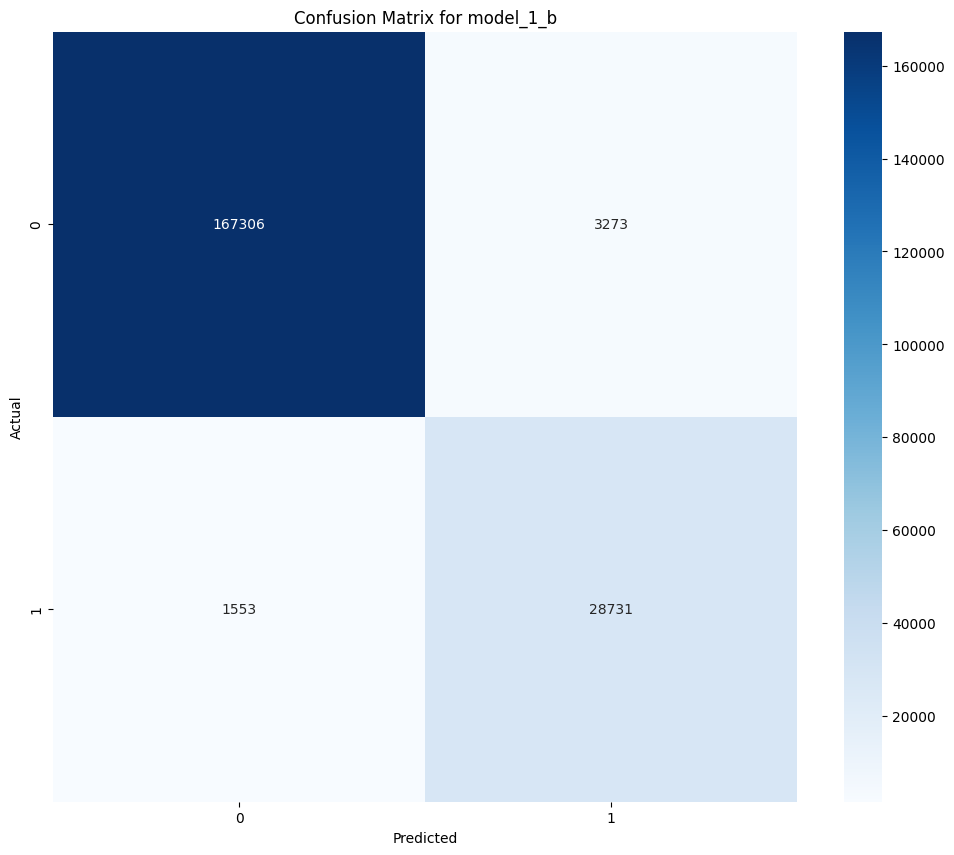

Confusion Matrix for model_2_b



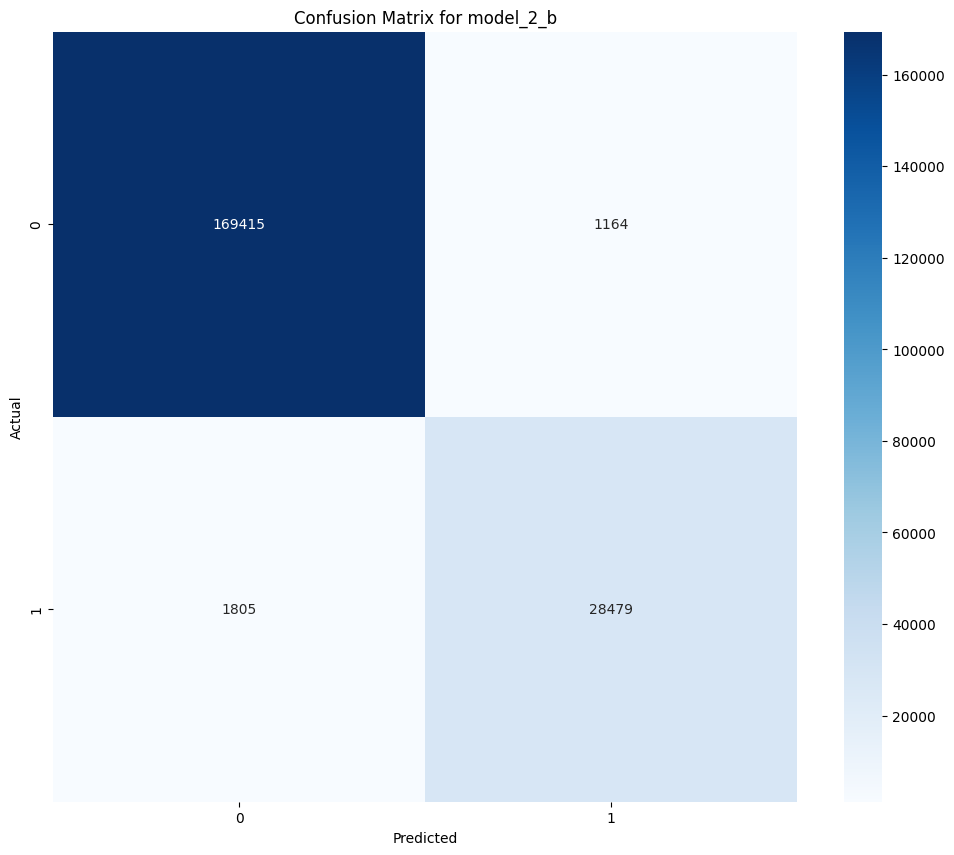

Confusion Matrix for model_3_b



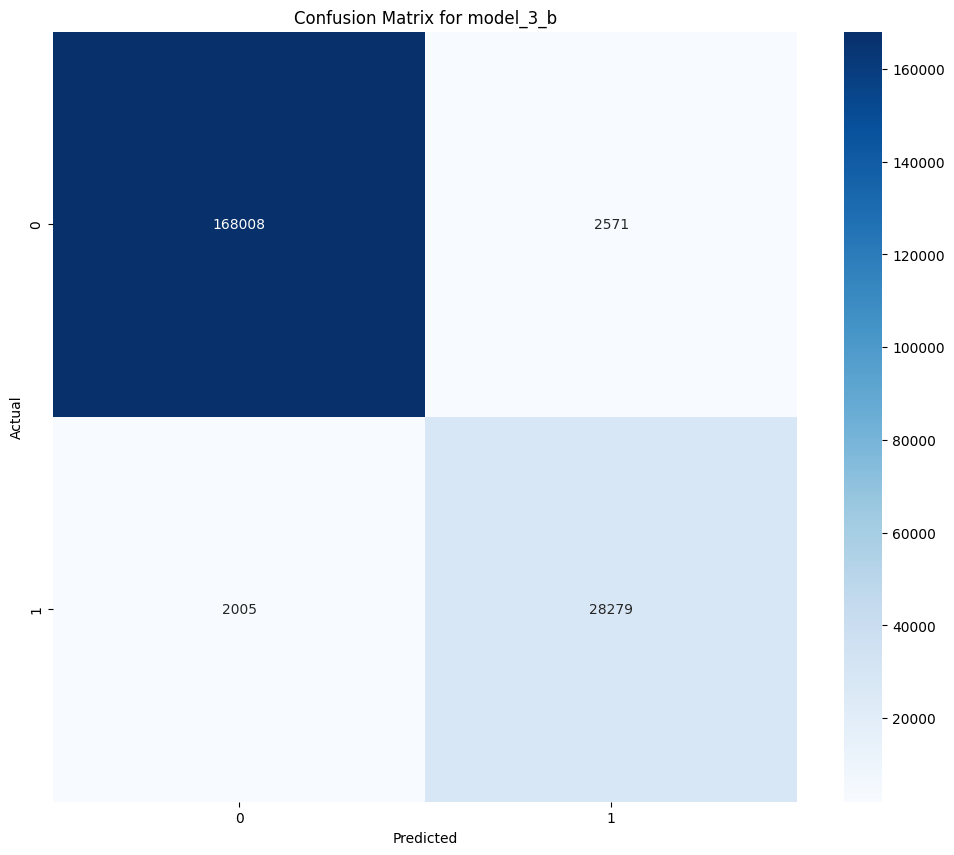

Confusion Matrix for model_4_b



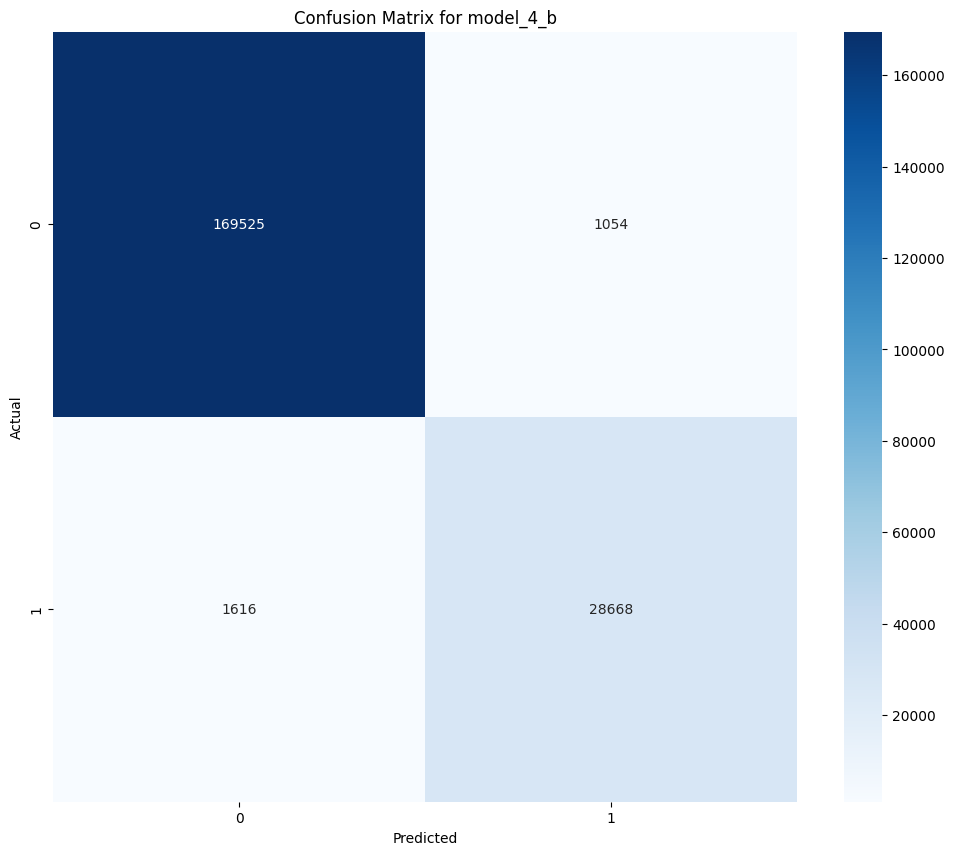

Confusion Matrix for model_5_b



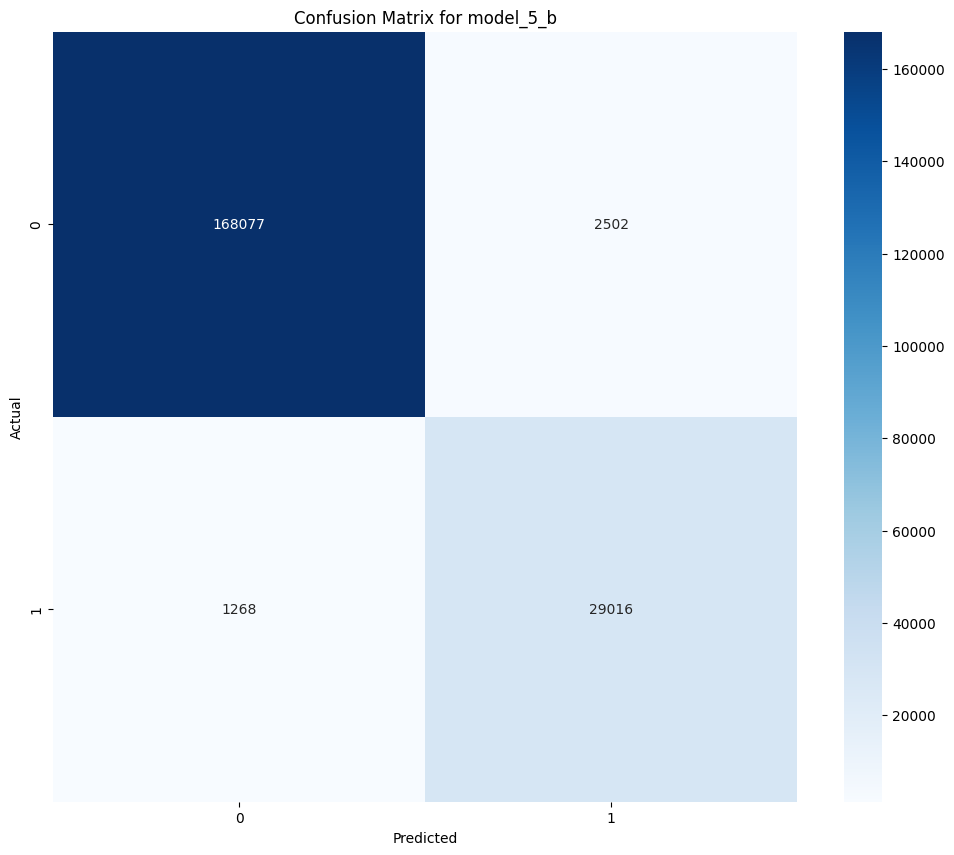

In [67]:
def confusion_matrix_plot(y_true, y_pred, model_name, normalize=False):
    """
    Plotting the confusion matrix for a model
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        cm = confusion_matrix(y_true, y_pred)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, None]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.grid(False)
        plt.show()


print("Confusion Matrix for model_1_b\n")
confusion_matrix_plot(y_test_b, y_pred_1_b, "model_1_b")

print("Confusion Matrix for model_2_b\n")
confusion_matrix_plot(y_test_b, y_pred_2_b, "model_2_b")

print("Confusion Matrix for model_3_b\n")
confusion_matrix_plot(y_test_b, y_pred_3_b, "model_3_b")

print("Confusion Matrix for model_4_b\n")
confusion_matrix_plot(y_test_b, y_pred_4_b, "model_4_b")

print("Confusion Matrix for model_5_b\n")
confusion_matrix_plot(y_test_b, y_pred_5_b, "model_5_b")


# ***2.2 Multiclassification***

## ***2.2.1 Classification Models***

In [68]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### ***A. Random forest***

In [69]:
"""
rf_pipeline = Pipeline([
    ('model', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced_subsample',
        n_jobs=2    

    ))
])

print("\n===== Random Forest Cross-Validation =====")
rf_cv_results = cross_validate(
    rf_pipeline,
    X_train_bal,
    y_train_bal,
    cv=cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)

"""

'\nrf_pipeline = Pipeline([\n    (\'model\', RandomForestClassifier(\n        n_estimators=100,\n        random_state=42,\n        class_weight=\'balanced_subsample\',\n        n_jobs=2    \n\n    ))\n])\n\nprint("\n===== Random Forest Cross-Validation =====")\nrf_cv_results = cross_validate(\n    rf_pipeline,\n    X_train_bal,\n    y_train_bal,\n    cv=cv,\n    scoring=[\'accuracy\', \'precision_macro\', \'recall_macro\', \'f1_macro\'],\n    n_jobs=-1,\n    return_train_score=False\n)\n\n'

In [70]:
"""
print(f"Accuracy: {np.mean(rf_cv_results['test_accuracy']):.3f} ± {np.std(rf_cv_results['test_accuracy']):.3f}")
print(f"Precision (macro): {np.mean(rf_cv_results['test_precision_macro']):.3f}")
print(f"Recall (macro): {np.mean(rf_cv_results['test_recall_macro']):.3f}")
print(f"F1-score (macro): {np.mean(rf_cv_results['test_f1_macro']):.3f}")

rf_pipeline.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_pipeline.predict(X_test_scaled)

print("\nRandom Forest Classification Report (Test Set):")
print(classification_report(y_test, y_pred_rf, digits=3))

ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test_scaled, y_test, cmap='YlOrRd')
plt.title("Random Forest Confusion Matrix")
plt.show()
"""

'\nprint(f"Accuracy: {np.mean(rf_cv_results[\'test_accuracy\']):.3f} ± {np.std(rf_cv_results[\'test_accuracy\']):.3f}")\nprint(f"Precision (macro): {np.mean(rf_cv_results[\'test_precision_macro\']):.3f}")\nprint(f"Recall (macro): {np.mean(rf_cv_results[\'test_recall_macro\']):.3f}")\nprint(f"F1-score (macro): {np.mean(rf_cv_results[\'test_f1_macro\']):.3f}")\n\nrf_pipeline.fit(X_train_bal, y_train_bal)\ny_pred_rf = rf_pipeline.predict(X_test_scaled)\n\nprint("\nRandom Forest Classification Report (Test Set):")\nprint(classification_report(y_test, y_pred_rf, digits=3))\n\nConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test_scaled, y_test, cmap=\'YlOrRd\')\nplt.title("Random Forest Confusion Matrix")\nplt.show()\n'

### ***B. XGBoost***

In [71]:
"""
xgb_pipeline = Pipeline([
    ('model', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',   
        eval_metric='logloss',
        scale_pos_weight=1,
        random_state=42,
        use_label_encoder=False,
        n_jobs=2  

    ))
])

print("\n===== XGBoost Cross-Validation =====")
xgb_cv_results = cross_validate(
    xgb_pipeline,
    X_train_bal,
    y_train_bal,
    cv=cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)

"""

'\nxgb_pipeline = Pipeline([\n    (\'model\', XGBClassifier(\n        n_estimators=200,\n        learning_rate=0.1,\n        max_depth=8,\n        subsample=0.8,\n        colsample_bytree=0.8,\n        objective=\'multi:softprob\',   \n        eval_metric=\'logloss\',\n        scale_pos_weight=1,\n        random_state=42,\n        use_label_encoder=False,\n        n_jobs=2  \n\n    ))\n])\n\nprint("\n===== XGBoost Cross-Validation =====")\nxgb_cv_results = cross_validate(\n    xgb_pipeline,\n    X_train_bal,\n    y_train_bal,\n    cv=cv,\n    scoring=[\'accuracy\', \'precision_macro\', \'recall_macro\', \'f1_macro\'],\n    n_jobs=-1,\n    return_train_score=False\n)\n\n'

In [72]:
"""
print(f"Accuracy: {np.mean(xgb_cv_results['test_accuracy']):.3f} ± {np.std(xgb_cv_results['test_accuracy']):.3f}")
print(f"Precision (macro): {np.mean(xgb_cv_results['test_precision_macro']):.3f}")
print(f"Recall (macro): {np.mean(xgb_cv_results['test_recall_macro']):.3f}")
print(f"F1-score (macro): {np.mean(xgb_cv_results['test_f1_macro']):.3f}")

xgb_pipeline.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb_pipeline.predict(X_test_scaled)

print("\nXGBoost Classification Report (Test Set):")
print(classification_report(y_test_b, y_pred_xgb, digits=3))

ConfusionMatrixDisplay.from_estimator(xgb_pipeline, X_test_scaled, y_test, cmap='YlOrRd')
plt.title("XGBoost Confusion Matrix")
plt.show()
"""

'\nprint(f"Accuracy: {np.mean(xgb_cv_results[\'test_accuracy\']):.3f} ± {np.std(xgb_cv_results[\'test_accuracy\']):.3f}")\nprint(f"Precision (macro): {np.mean(xgb_cv_results[\'test_precision_macro\']):.3f}")\nprint(f"Recall (macro): {np.mean(xgb_cv_results[\'test_recall_macro\']):.3f}")\nprint(f"F1-score (macro): {np.mean(xgb_cv_results[\'test_f1_macro\']):.3f}")\n\nxgb_pipeline.fit(X_train_bal, y_train_bal)\ny_pred_xgb = xgb_pipeline.predict(X_test_scaled)\n\nprint("\nXGBoost Classification Report (Test Set):")\nprint(classification_report(y_test_b, y_pred_xgb, digits=3))\n\nConfusionMatrixDisplay.from_estimator(xgb_pipeline, X_test_scaled, y_test, cmap=\'YlOrRd\')\nplt.title("XGBoost Confusion Matrix")\nplt.show()\n'

## ***2.2.3 MLP Model***

In [73]:
num_classes = len(np.unique(y_train_bal))  # number of classes in your training set
input_shape = X_train_bal.shape[1]         # number of features

In [74]:
# model_1_m - An intermediate architecture

model_1_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# model_2_m - An intermediate architecture
model_2_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# model_3_m - An intermediate architecture
model_3_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])
# model_4_m - An intermediate architecture
model_4_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# model_5_m - The "maximal" architecture
model_5_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(32, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

models_m = [model_1_m, model_2_m, model_3_m, model_4_m, model_5_m]

In [75]:

# Define Early Stopping callback to monitor validation loss
early_stopping_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=8,                # Stop training after 10 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=4,                # Default value for patience is 10
    min_lr= 1e-07,             # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=0,                 # Providing verbose output when learning rate is reduced
    factor= 0.1)               # The default factor is 0.1, which reduces 
                               # the learning rate by 10% when triggered.
    
compilation_params_m = dict(
    optimizer='adam',          # Adam optimizer has default learning rate 1e-03
    loss='sparse_categorical_crossentropy',  # Sparse categoriical crossentropy 
                                             # corresponds to Multiclass Configuration 
    metrics=['accuracy'])      # montitor accuracy during training

In [76]:
# Training Session for `model_1_m`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_1_m.compile(**compilation_params_m) 

fitting_params_m = dict(x=X_train_bal, y=y_train_bal, validation_data=(X_val_scaled, y_val),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

history_1_m = model_1_m.fit(**fitting_params_m)

Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 16.


In [77]:
# Training Session for `model_2_m`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_2_m.compile(**compilation_params_m) 
 
fitting_params_m = dict(x=X_train_bal, y=y_train_bal, validation_data=(X_val_scaled, y_val),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

history_2_m = model_2_m.fit(**fitting_params_m)

Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 13.


In [78]:
# Training Session for `model_3_m`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_3_m.compile(**compilation_params_m) 

fitting_params_m = dict(x=X_train_bal, y=y_train_bal, validation_data=(X_val_scaled, y_val),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

history_3_m = model_3_m.fit(**fitting_params_m)

Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 18.


In [79]:
# Training Session for `model_4_m`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_4_m.compile(**compilation_params_m) 

fitting_params_m = dict(x=X_train_bal, y=y_train_bal, validation_data=(X_val_scaled, y_val),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

history_4_m = model_4_m.fit(**fitting_params_m)

Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 22.


In [80]:
# Training Session for `model_5_m`

early_stopping = EarlyStopping(**early_stopping_params)

reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
model_5_m.compile(**compilation_params_m) 

fitting_params_m = dict(x=X_train_bal, y=y_train_bal, validation_data=(X_val_scaled, y_val),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)
 
history_5_m = model_5_m.fit(**fitting_params_m)

Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 43.


In [81]:
def evaluate_m(model, X_test, y_test):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1)
    recall    = recall_score(y_test, y_pred_labels, average='weighted', zero_division=1)
    f1        = f1_score(y_test, y_pred_labels, average='weighted', zero_division=1)

    # Print the evaluation metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1 Score:  {f1*100:.2f}%")
    print("")
    
    return test_loss, test_accuracy, precision, recall, f1
       
[loss_1_m, acc_1_m, prec_1_m, recall_1_m, f1_1_m] = evaluate_m(model_1_m,
                X_test=X_test_scaled, y_test=y_test)
[loss_2_m, acc_2_m, prec_2_m, recall_2_m, f1_2_m] = evaluate_m(model_2_m,
                X_test=X_test_scaled, y_test=y_test)
[loss_3_m, acc_3_m, prec_3_m, recall_3_m, f1_3_m] = evaluate_m(model_3_m,
                X_test=X_test_scaled, y_test=y_test)
[loss_4_m, acc_4_m, prec_4_m, recall_4_m, f1_4_m] = evaluate_m(model_4_m,
                X_test=X_test_scaled, y_test=y_test)
[loss_5_m, acc_5_m, prec_5_m, recall_5_m, f1_5_m] = evaluate_m(model_5_m,
                X_test=X_test_scaled, y_test=y_test)

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9103 - loss: 0.2760
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Test Loss:      0.2794
Test Accuracy:  91.00%
Test Precision: 97.24%
Test Recall:    91.00%
Test F1 Score:  93.59%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9307 - loss: 0.2003
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Test Loss:      0.2008
Test Accuracy:  93.05%
Test Precision: 98.10%
Test Recall:    93.05%
Test F1 Score:  95.26%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9360 - loss: 0.1859
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Test Loss:      0.1863
Test Accuracy:  93.60%
Test Precision: 98.37%
Test Recall:    93.60%
Test F1 Score:  95.70%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9302 - loss: 0.1849
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Test Loss:      0.1863
Test Accuracy:  93.02%
Test Precision: 97.68%
Test Recall:    93.02%
Test F1 Score:  94.99%

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accura

In [82]:
def far(conf_matrix, benign_index):
    # Calculate the total number of instances for the Benign Class
    total_benign_instances = np.sum(conf_matrix[benign_index,:])
    # Calculate the False Positives of the Benign Class
    false_positives = total_benign_instances - conf_matrix[benign_index, benign_index]
    # Calculate FAR
    far = false_positives / total_benign_instances
    return far
    

In [83]:
def amr(conf_matrix, benign_index):
    # Calculate the total number of instances for the Benign Class
    total_benign_instances = np.sum(conf_matrix[benign_index,:])
    # Calculate the total number of instances for all classes
    total_instances = np.sum(conf_matrix)
    # Extract the total number of attack/malicious instances
    total_attack_instances = total_instances - total_benign_instances
    # Calculate the False Positives for the union of all attacks
    false_positives = np.sum(conf_matrix[benign_index + 1:, benign_index], axis=0)
    # Calculate AMR
    amr = false_positives / total_attack_instances
    return amr

In [84]:
def far_amr_m(model, X_test=X_test_scaled, y_test=y_test, plotting=True):
    """
    Advanced evaluation through False Alarm Ratio (FAR) & Attack Miss Ratio (AMR).
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Plotting parameter exists for debugging purposes
    if plotting:
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    far_m = far(conf_matrix=conf_matrix, benign_index=0)
    amr_m = amr(conf_matrix=conf_matrix, benign_index=0)
    return far_m, amr_m
    
far_1_m, amr_1_m = far_amr_m(model_1_m, plotting=False)
far_2_m, amr_2_m = far_amr_m(model_2_m, plotting=False)
far_3_m, amr_3_m = far_amr_m(model_3_m, plotting=False)
far_4_m, amr_4_m = far_amr_m(model_4_m, plotting=False)
far_5_m, amr_5_m = far_amr_m(model_5_m, plotting=False)

print("")
print(f"Model_1_m: (FAR, AMR) = ({far_1_m:.4f}, {amr_1_m:.4f})")
print(f"Model_2_m: (FAR, AMR) = ({far_2_m:.4f}, {amr_2_m:.4f})")
print(f"Model_3_m: (FAR, AMR) = ({far_3_m:.4f}, {amr_3_m:.4f})")
print(f"Model_4_m: (FAR, AMR) = ({far_4_m:.4f}, {amr_4_m:.4f})")
print(f"Model_5_m: (FAR, AMR) = ({far_5_m:.4f}, {amr_5_m:.4f})")

6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6277/6277 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

Model_1_m: (FAR, AMR) = (0.1045, 0.0028)
Model_2_m: (FAR, AMR) = (0.0778, 0.0040)
Model_3_m: (FAR, AMR) = (0.0733, 0.0064)
Model_4_m: (FAR, AMR) = (0.0805, 0.0030)
Model_5_m: (FAR, AMR) = (0.0160, 0.0021)


History for model_1_m



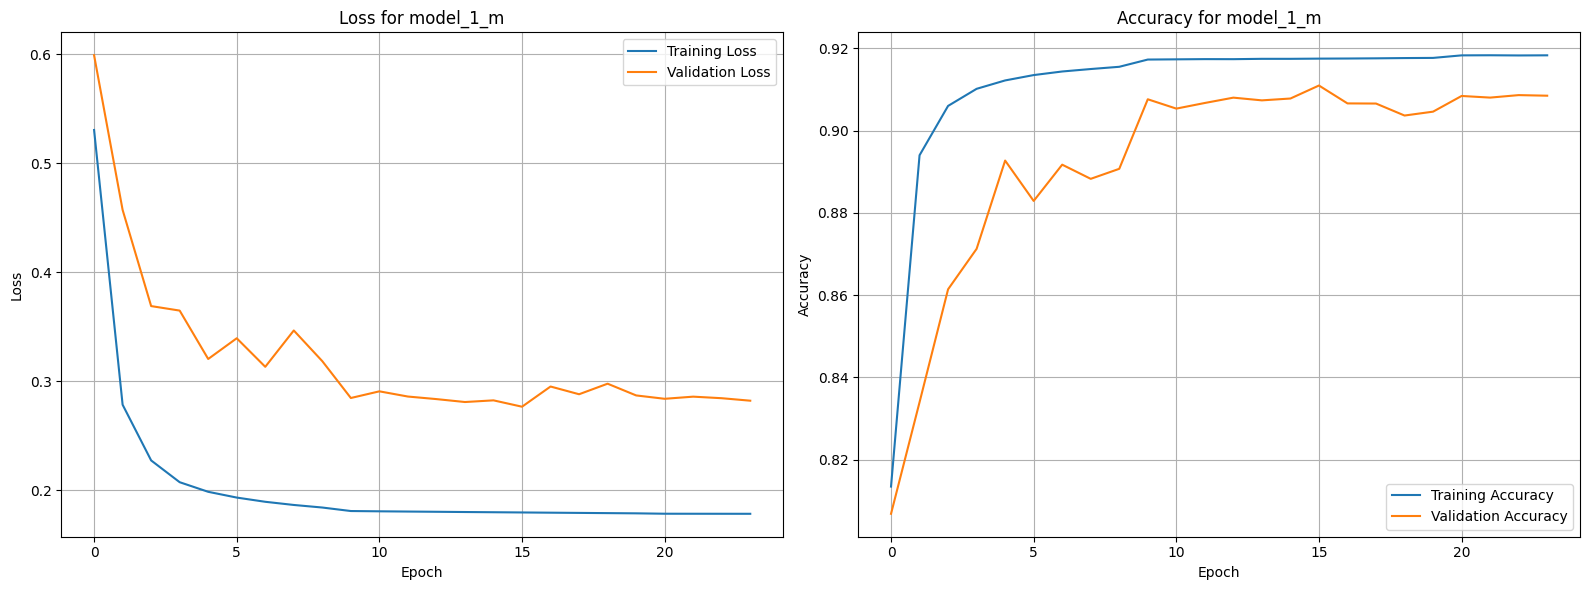


History for model_2_m



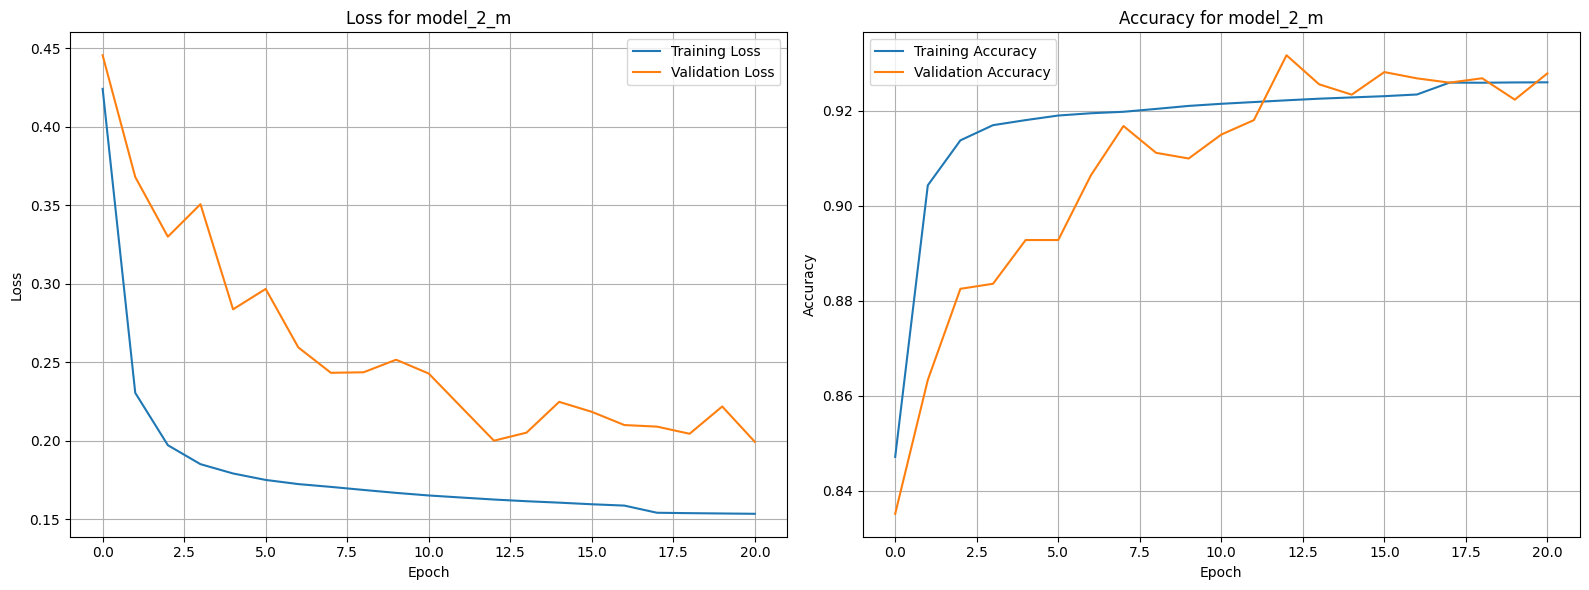


History for model_3_m



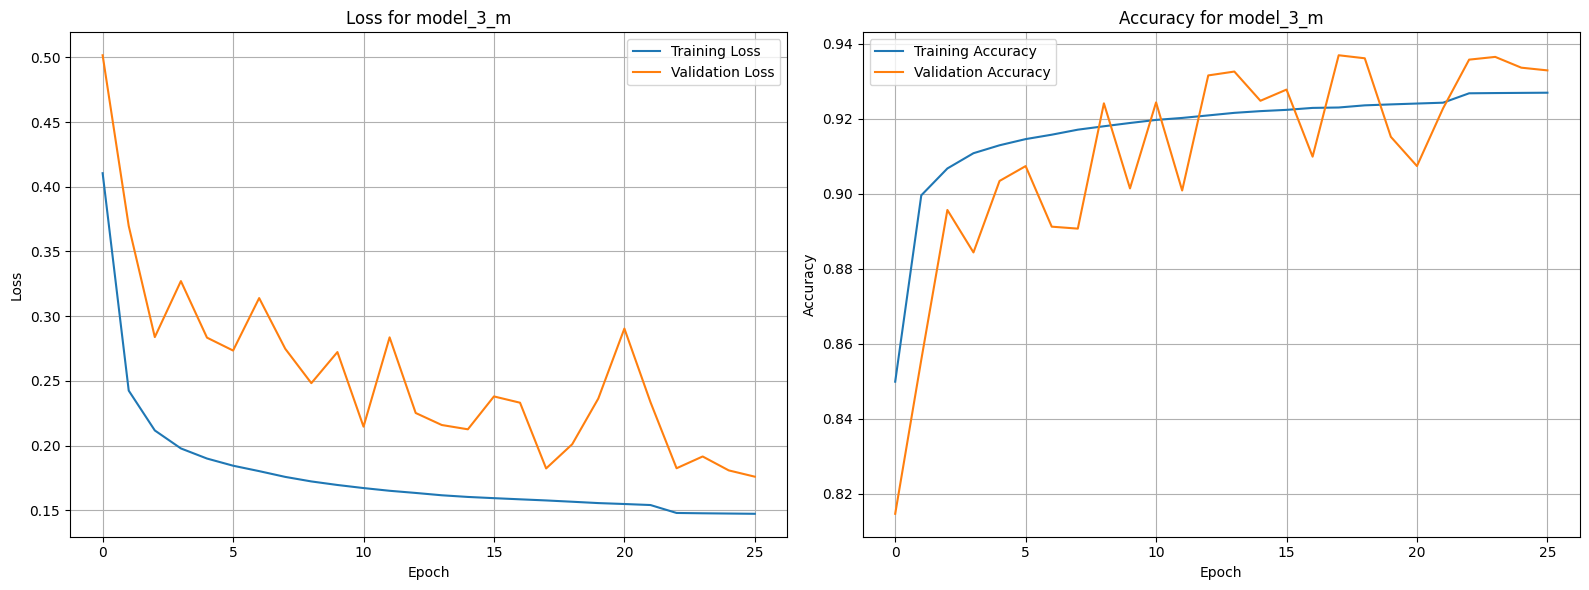


History for model_4_m



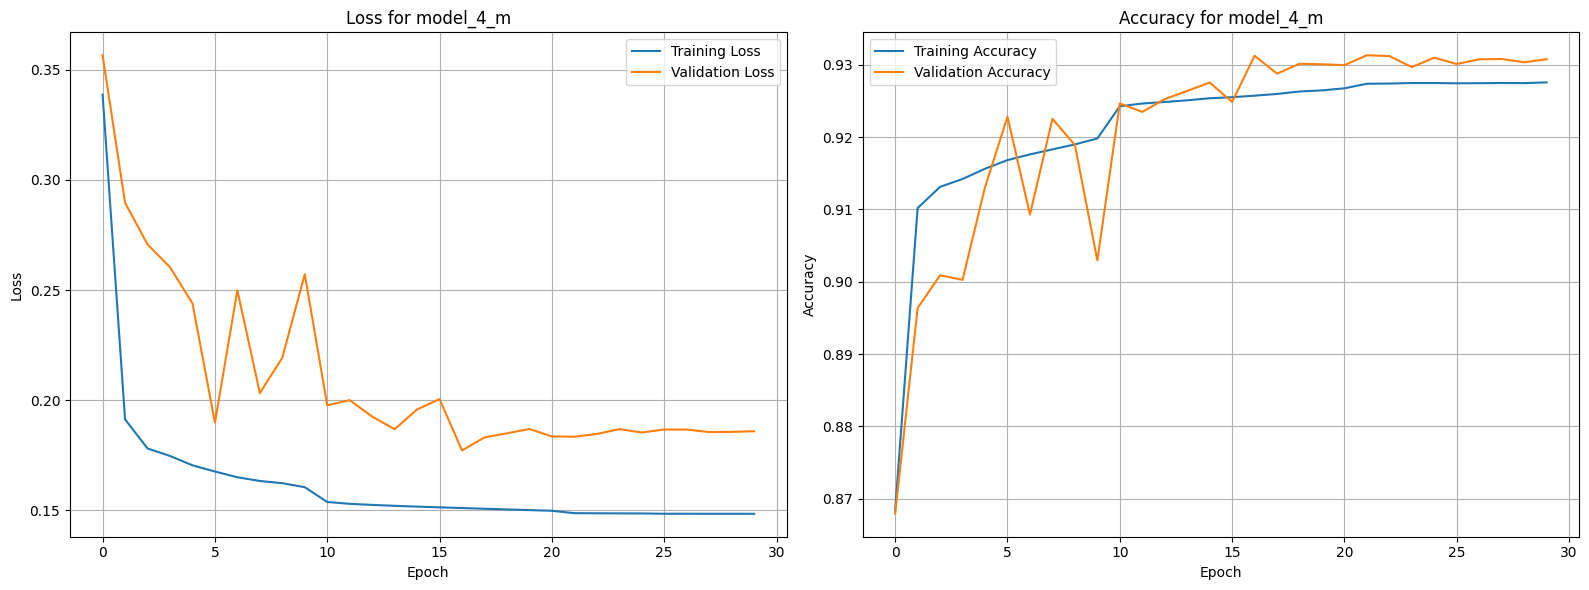


History for model_5_m



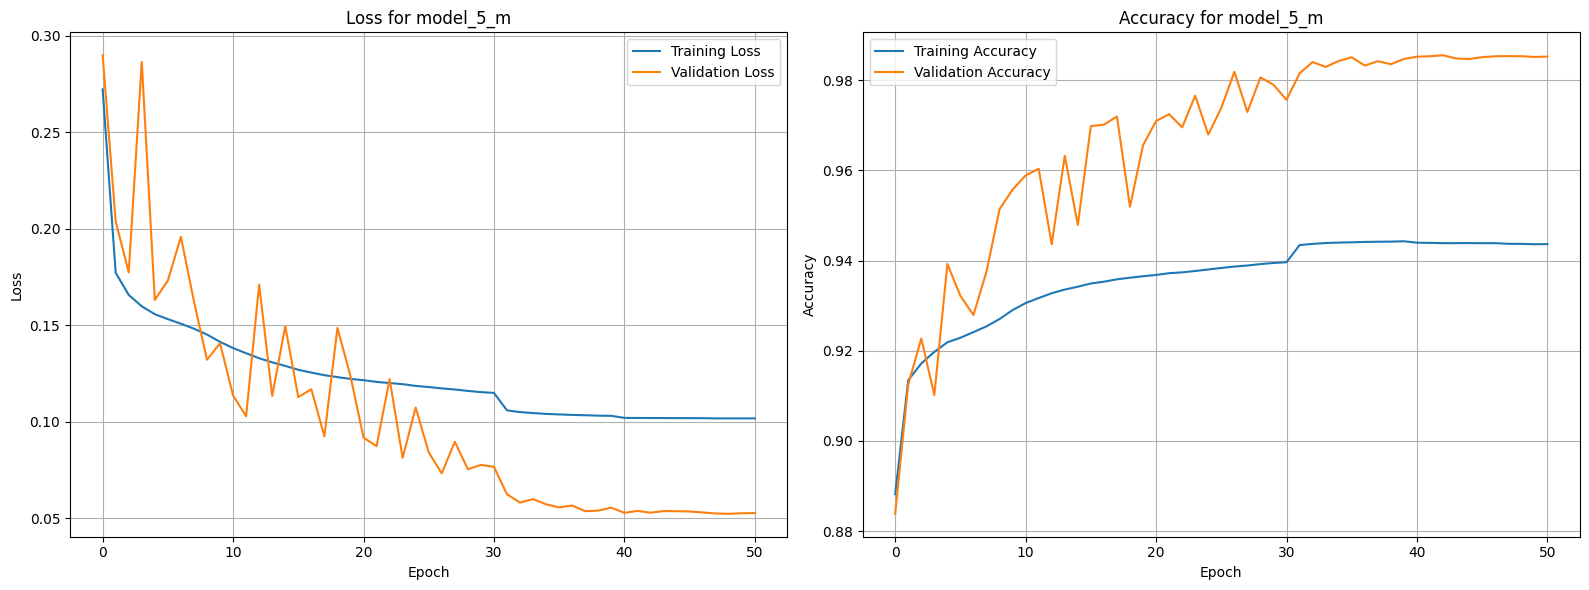

In [85]:
print("History for model_1_m\n")
history_plot(history_1_m, "model_1_m")
print("")
print("History for model_2_m\n")
history_plot(history_2_m, "model_2_m")
print("")
print("History for model_3_m\n")
history_plot(history_3_m, "model_3_m")
print("")
print("History for model_4_m\n")
history_plot(history_4_m, "model_4_m")
print("")
print("History for model_5_m\n")
history_plot(history_5_m, "model_5_m")

In [86]:
acc_m = [acc_1_m, acc_2_m, acc_3_m, acc_4_m, acc_5_m]

# Plot
plt.plot(num_params_m, acc_m, marker='o')
plt.title('Accuracy vs Number of Parameters: Multi-class Configuration')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

NameError: name 'num_params_m' is not defined

In [ ]:
# Measure & Print latency
print(f"Latency for model_1_m: {latency(model_1_m, X_test_scaled)*1000:.3f} ms") # Results: 0.052 m-seconds
print(f"Latency for model_2_m: {latency(model_2_m, X_test_scaled)*1000:.3f} ms") # Results: 0.052 m-seconds
print(f"Latency for model_3_m: {latency(model_3_m, X_test_scaled)*1000:.3f} ms") # Results: 0.053 m-seconds
print(f"Latency for model_4_m: {latency(model_4_m, X_test_scaled)*1000:.3f} ms") # Results: 0.051 m-seconds
print(f"Latency for model_5_m: {latency(model_5_m, X_test_scaled)*1000:.3f} ms") # Results: 0.049 m-seconds

In [ ]:
y_pred_1 = (model_1_m.predict(X_test_scaled) > 0.5).astype(int)
y_pred_2 = (model_2_m.predict(X_test_scaled) > 0.5).astype(int)
y_pred_3 = (model_3_m.predict(X_test_scaled) > 0.5).astype(int)
y_pred_4 = (model_4_m.predict(X_test_scaled) > 0.5).astype(int)
y_pred_5 = (model_5_m.predict(X_test_scaled) > 0.5).astype(int)

In [ ]:
def confusion_matrix_plot(y_true, y_pred, model_name, normalize=False):
    """
    Plotting the confusion matrix for a model
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        cm = confusion_matrix(y_true, y_pred)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, None]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.grid(False)
        plt.show()


print("Confusion Matrix for model_1_b\n")
confusion_matrix_plot(y_test_b, y_pred_1, "model_1_m")

print("Confusion Matrix for model_2_b\n")
confusion_matrix_plot(y_test, y_pred_2, "model_2_m")

print("Confusion Matrix for model_3_b\n")
confusion_matrix_plot(y_test, y_pred_3, "model_3_m")

print("Confusion Matrix for model_4_b\n")
confusion_matrix_plot(y_test, y_pred_4, "model_4_m")

print("Confusion Matrix for model_5_b\n")
confusion_matrix_plot(y_test, y_pred_5, "model_5_m")
